In [ ]:
! pip install scikeras
! pip install git+https://github.com/modAL-python/modAL.git
# !pip install --upgrade scikit-learn scikeras

## **Imports**

In [2]:
import keras
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.datasets import cifar10
from modAL.models import ActiveLearner
from keras.applications import ResNet50
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Flatten, Dense
from modAL.disagreement import consensus_entropy_sampling
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## **Defining the Model**

In [5]:
def create_keras_model():
    
    input_shape = (32, 32, 3)

    # Load pre-trained ResNet50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)  # Assuming 10 classes for classification
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

## **Defining the Random Sampling Function**

In [6]:
def random_sampling(classifier, X_pool, n_instances):
    query_idx = np.random.choice(range(len(X_pool)), size=n_instances, replace=False)
    return query_idx, X_pool[query_idx]

## **Defining the Loading and Splitting Function**

In [7]:
def initialize_data(n_initial):
    
    np.random.seed(42)

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    initial_indices = []
    n_initial_per_class = n_initial // len(np.unique(y_train))
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        selected_indices = np.random.choice(class_indices, size=n_initial_per_class, replace=False)
        initial_indices.extend(selected_indices)
    np.random.shuffle(initial_indices)
    selected_initial_indices = initial_indices[:n_initial]

    X_initial = X_train[selected_initial_indices]
    y_initial = y_train[selected_initial_indices]

    X_pool = np.delete(X_train, selected_initial_indices, axis=0)
    y_pool = np.delete(y_train, selected_initial_indices, axis=0)

    return X_initial, y_initial, X_pool, y_pool, X_test, y_test

## **Defining the Active Learning Function**

In [8]:
def active_learning_strategy(query_strategy , X_initial, y_initial, X_pool, y_pool, X_test, y_test):
    classifier = KerasClassifier(create_keras_model, batch_size=1)
    learner = ActiveLearner(estimator=classifier, query_strategy=query_strategy, X_training=X_initial, y_training=y_initial, verbose=1)
    f1_scores = []
    accuracies = []
    for idx in range(15):
        query_idx, _ = learner.query(X_pool, n_instances=2500)
        learner.teach(X=X_pool[query_idx], y=y_pool[query_idx], only_new=False, verbose=1)
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        y_pred = learner.predict(X_test)
        y_test_int = np.argmax(y_test, axis=1)
        y_pred_int = np.argmax(y_pred, axis=1)

        f1 = f1_score(y_test_int, y_pred_int, average='weighted')
        f1_scores.append(f1)
        accuracy = accuracy_score(y_test_int, y_pred_int)
        accuracies.append(accuracy)

        print(f"\033[1mIteration {idx + 1}:\033[0m \n\033[1mF1 Score\033[0m: {f1}")
        print("\033[1mAccuracy:\033[0m", accuracy)
        print()

        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test_int, y_pred_int), annot=True, fmt='d', cmap='copper', xticklabels=np.unique(y_test_int), yticklabels=np.unique(y_test_int))
        plt.title(f'Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return f1_scores, accuracies

## **Defining the Plotting Function**

In [9]:
def plot_metrics(f1_scores, accuracies, stategy_name):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(range(len(f1_scores)), f1_scores, marker='o')
    axs[0].set_xlabel('Active Learning Cycle')
    axs[0].set_ylabel('F1 Score')
    axs[0].set_title(f'F1 Score Improvement through the Active Learning Cycle Using {stategy_name}')
    axs[0].grid(True)

    axs[1].plot(range(len(accuracies)), accuracies, marker='o')
    axs[1].set_xlabel('Active Learning Cycle')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title(f'Accuracy Improvement through the Active Learning Cycle Using {stategy_name}')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

## **Loading and Splitting the Data**

In [10]:
n_initial = 5000
X_initial, y_initial, X_pool, y_pool, X_test, y_test = initialize_data(n_initial)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## **The Active Learning Cycle Using Random Sampling**

Running active learning using random sampling: 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.3153 - loss: 1.9960


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.3352 - loss: 1.9150
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 1: 
F1 Score: 0.4465839174175726
Accuracy: 0.4757



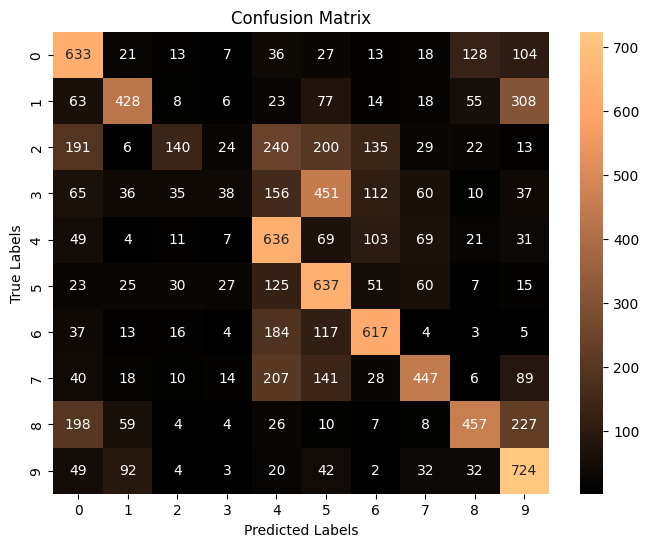

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.3585 - loss: 1.8436
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step
Iteration 2: 
F1 Score: 0.45617013387816086
Accuracy: 0.4667



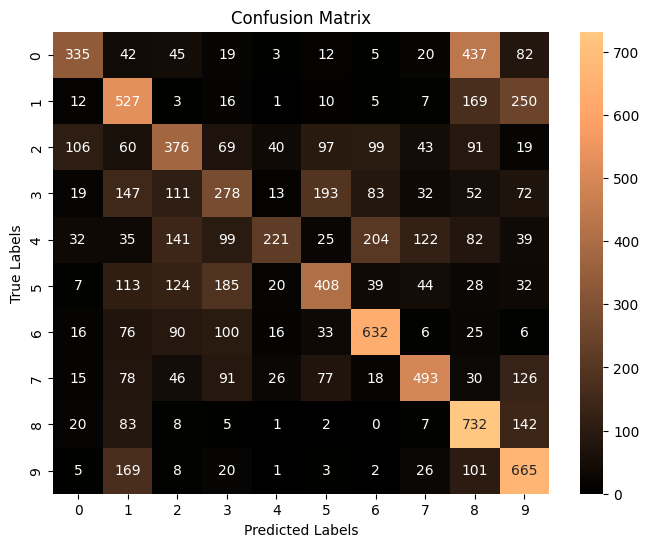

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.3680 - loss: 1.8185
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 3: 
F1 Score: 0.4557517386705103
Accuracy: 0.4506



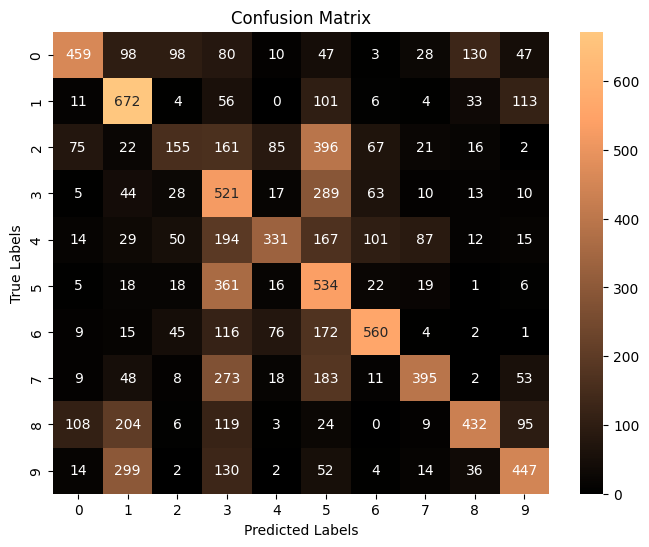

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 105s 6ms/step - accuracy: 0.3898 - loss: 1.7699
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step
Iteration 4: 
F1 Score: 0.49468280610408055
Accuracy: 0.504



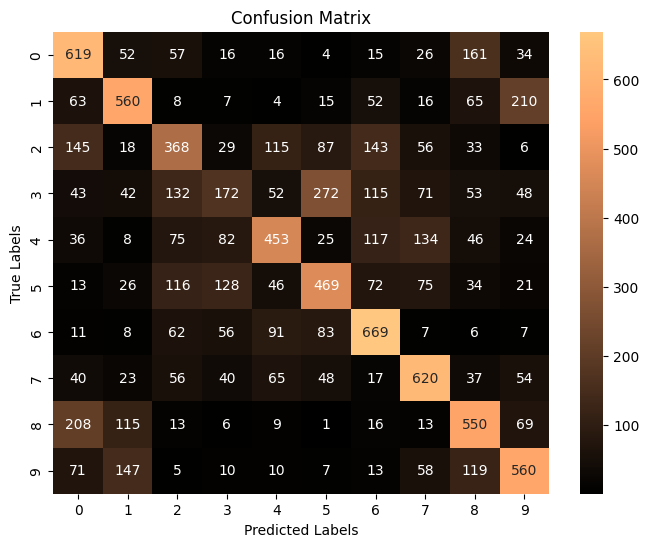

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 126s 7ms/step - accuracy: 0.3922 - loss: 1.7373
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step
Iteration 5: 
F1 Score: 0.5007187260309204
Accuracy: 0.5095



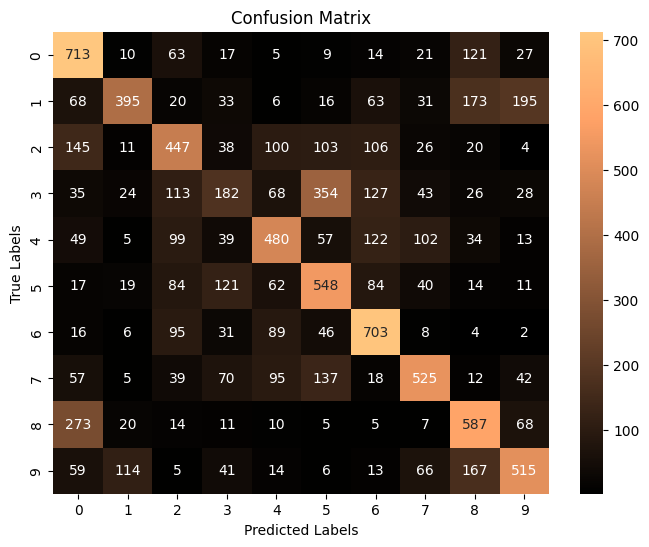

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - accuracy: 0.3913 - loss: 1.7358
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step
Iteration 6: 
F1 Score: 0.5153827094336364
Accuracy: 0.5221



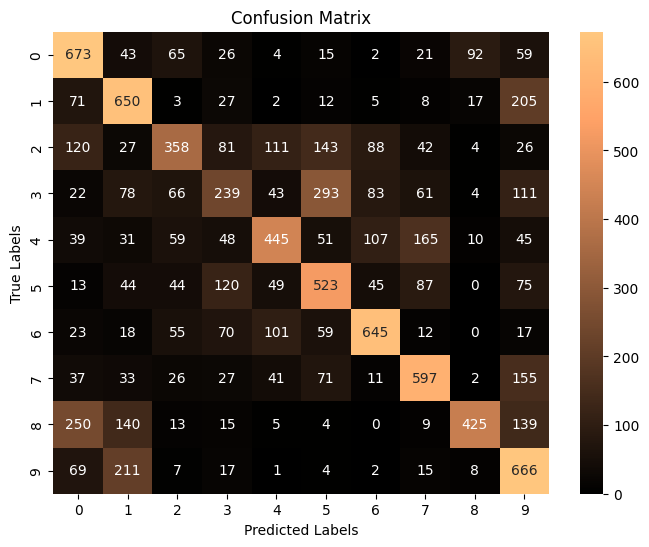

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.4047 - loss: 1.7211
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 7: 
F1 Score: 0.5257395440291285
Accuracy: 0.5408



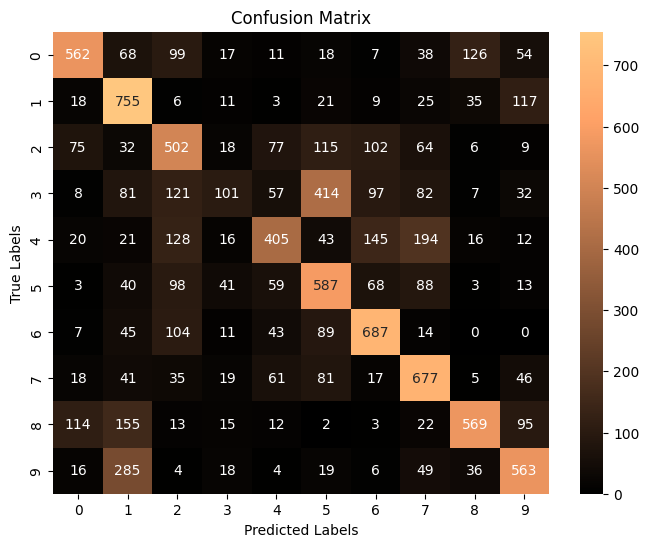

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 167s 6ms/step - accuracy: 0.4200 - loss: 1.6792
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 8: 
F1 Score: 0.5021948448814337
Accuracy: 0.5125



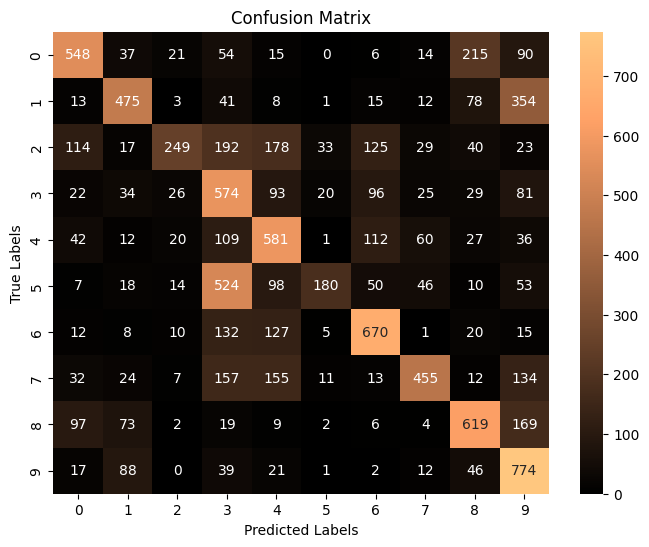

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


27500/27500 ━━━━━━━━━━━━━━━━━━━━ 184s 6ms/step - accuracy: 0.4179 - loss: 1.6887
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 9: 
F1 Score: 0.5335322124415177
Accuracy: 0.5355



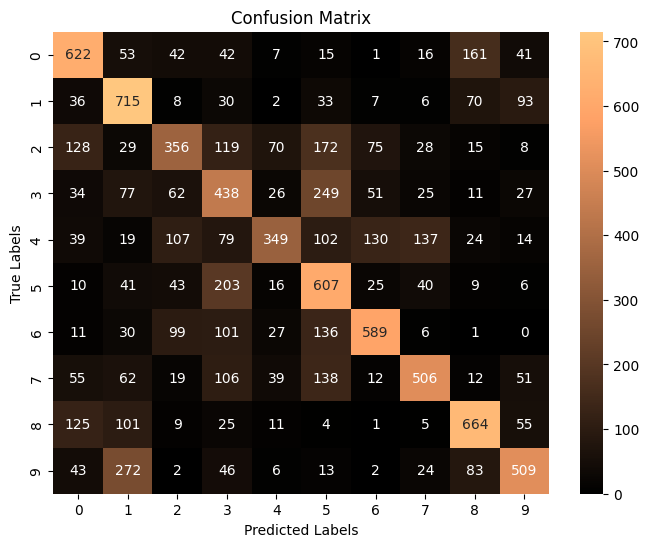

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - accuracy: 0.4191 - loss: 1.6721
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step
Iteration 10: 
F1 Score: 0.5047050885902595
Accuracy: 0.52



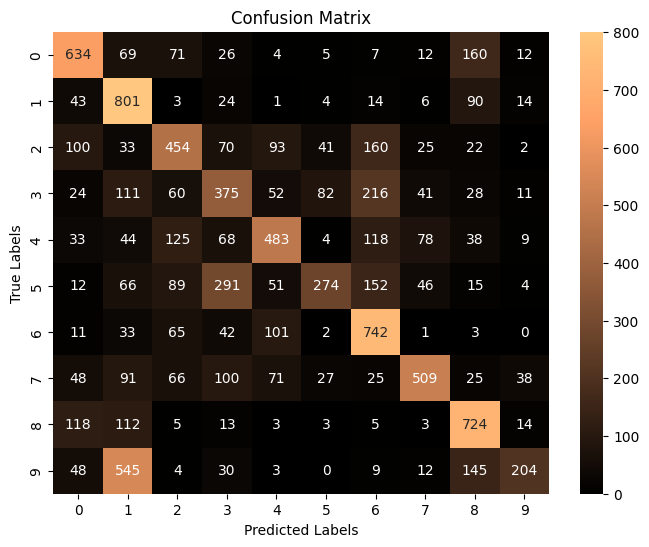

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


32500/32500 ━━━━━━━━━━━━━━━━━━━━ 216s 6ms/step - accuracy: 0.4245 - loss: 1.6487
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step
Iteration 11: 
F1 Score: 0.520596419957275
Accuracy: 0.5236



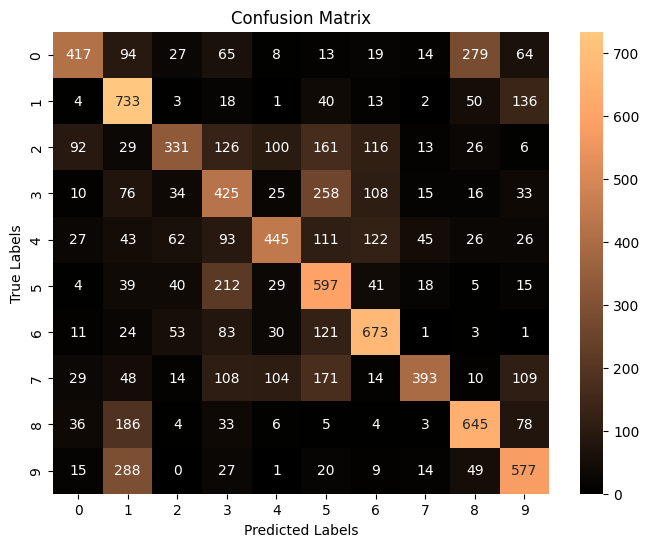

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 228s 6ms/step - accuracy: 0.4262 - loss: 1.6614
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 12: 
F1 Score: 0.5392383359165892
Accuracy: 0.5419



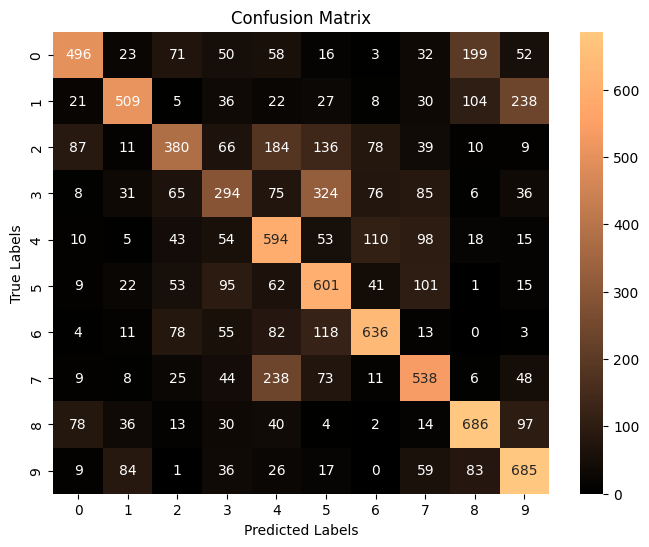

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


37500/37500 ━━━━━━━━━━━━━━━━━━━━ 245s 6ms/step - accuracy: 0.4350 - loss: 1.6119
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 13: 
F1 Score: 0.5620471236367159
Accuracy: 0.565



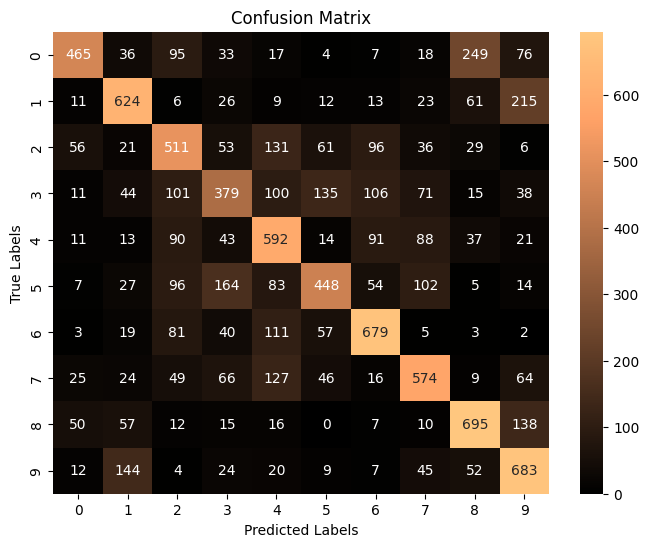

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 260s 6ms/step - accuracy: 0.4351 - loss: 1.6025
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 14: 
F1 Score: 0.5163966574320149
Accuracy: 0.533



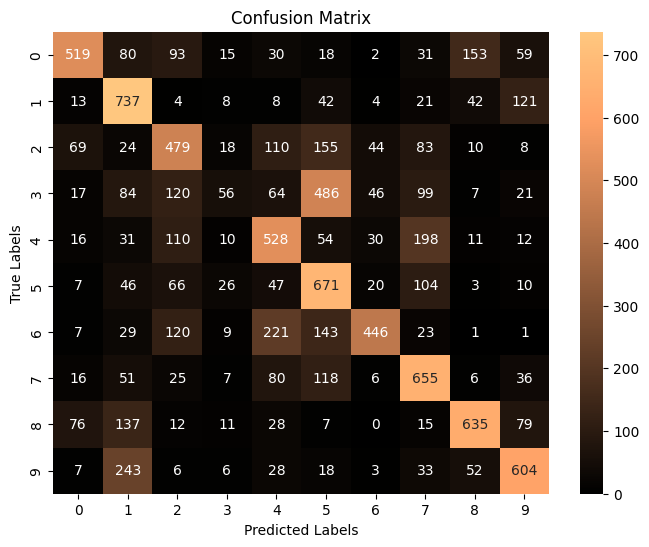

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


42500/42500 ━━━━━━━━━━━━━━━━━━━━ 275s 6ms/step - accuracy: 0.4389 - loss: 1.6109
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 15: 
F1 Score: 0.5373580695674027
Accuracy: 0.5425



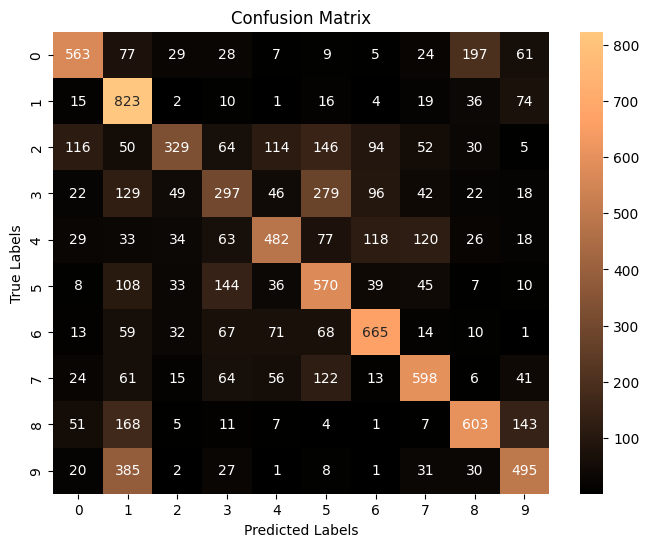

In [9]:
# Running active learning loops
print("Running active learning using random sampling: ")
f1_scores_random_sampling, accuracy_random_sampling = active_learning_strategy(random_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Random Sampling Cycle**

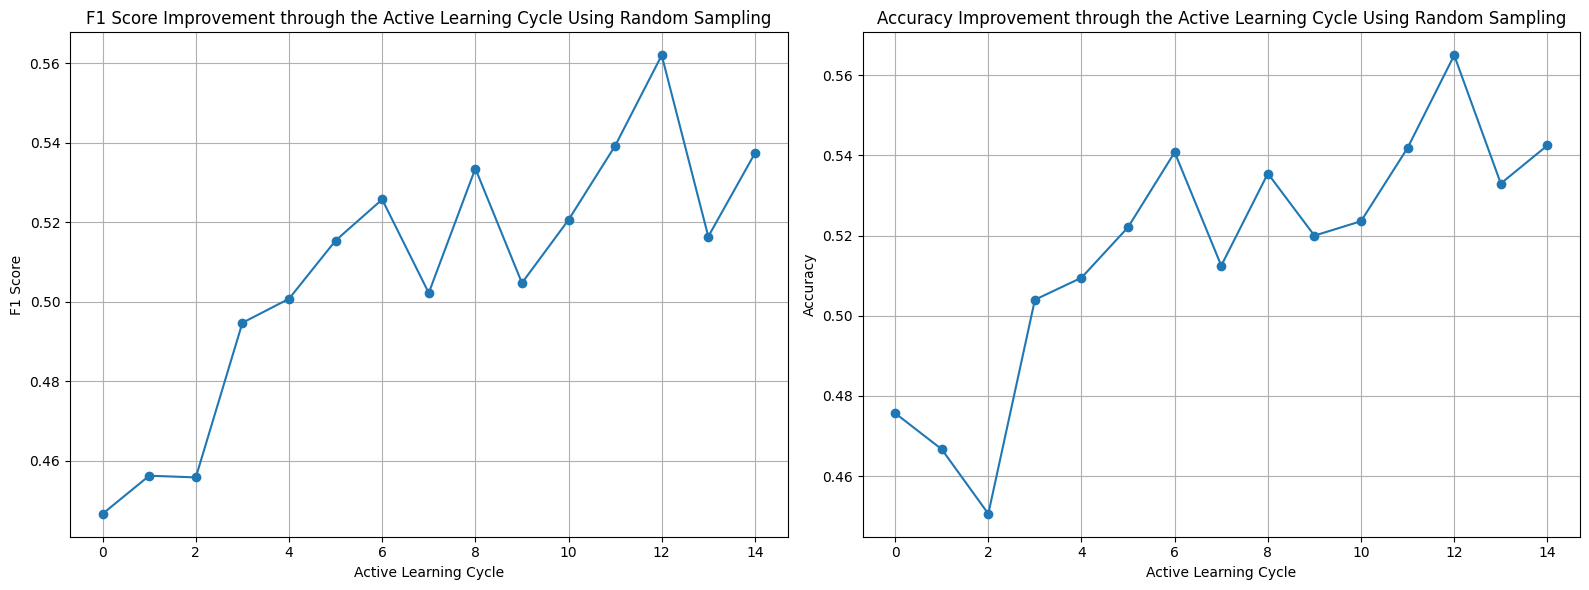

In [10]:
plot_metrics(f1_scores_random_sampling, accuracy_random_sampling, "Random Sampling")

## **The Active Learning Cycle Using Entropy Sampling**

Running active learning using entropy sampling: 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.3204 - loss: 1.9708
45191/45191 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.3054 - loss: 1.9997
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 1: 
F1 Score: 0.43078936526203626
Accuracy: 0.4549



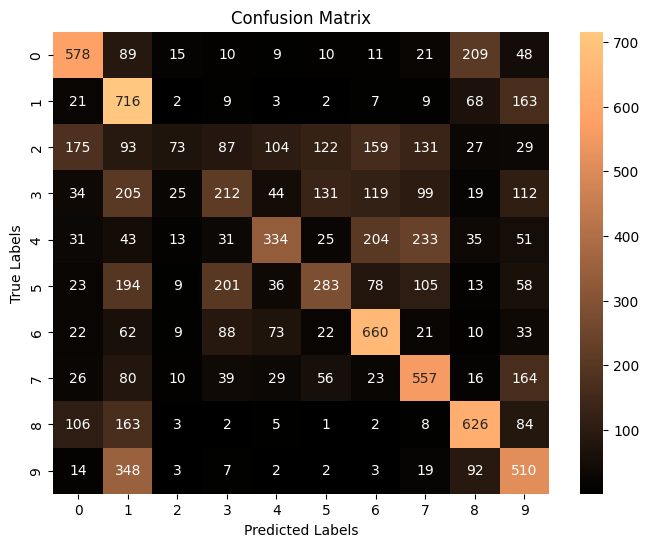

42691/42691 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.2823 - loss: 2.0379
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 2: 
F1 Score: 0.4793709233805612
Accuracy: 0.4817



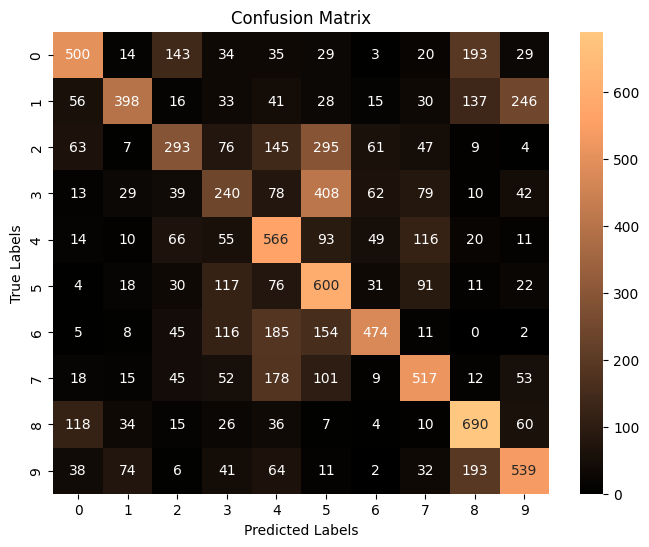

40191/40191 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.2816 - loss: 2.0632
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 3: 
F1 Score: 0.44726888607783993
Accuracy: 0.4671



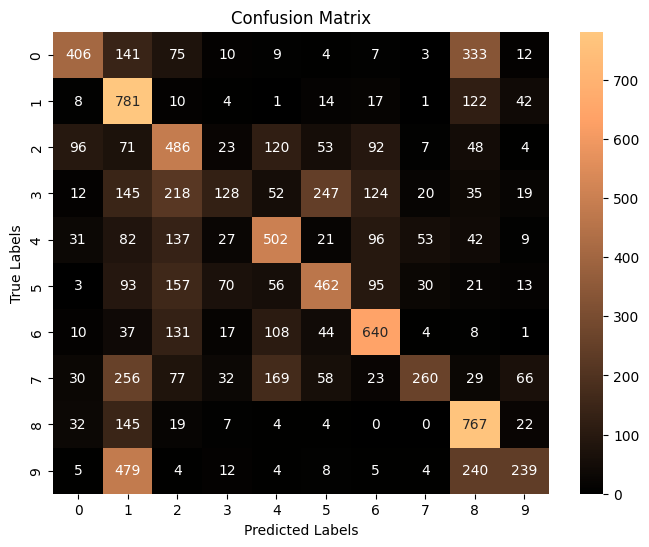

37691/37691 ━━━━━━━━━━━━━━━━━━━━ 156s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - accuracy: 0.2610 - loss: 2.0829
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 4: 
F1 Score: 0.4443661745837549
Accuracy: 0.4542



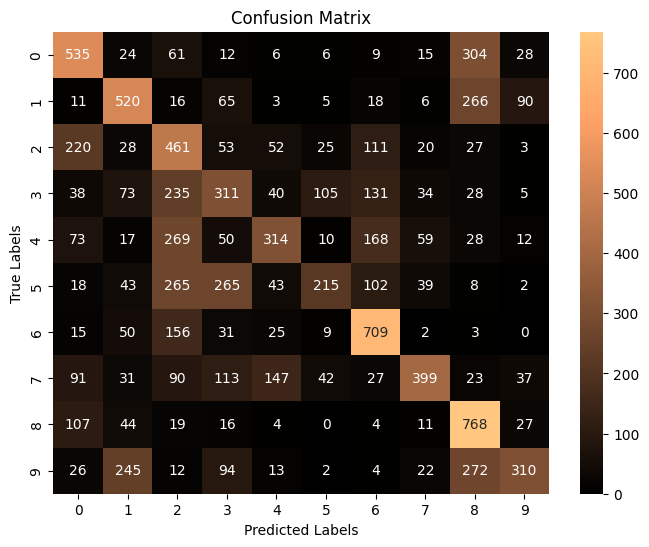

35191/35191 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.2797 - loss: 2.0188
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 5: 
F1 Score: 0.4758643816243135
Accuracy: 0.4812



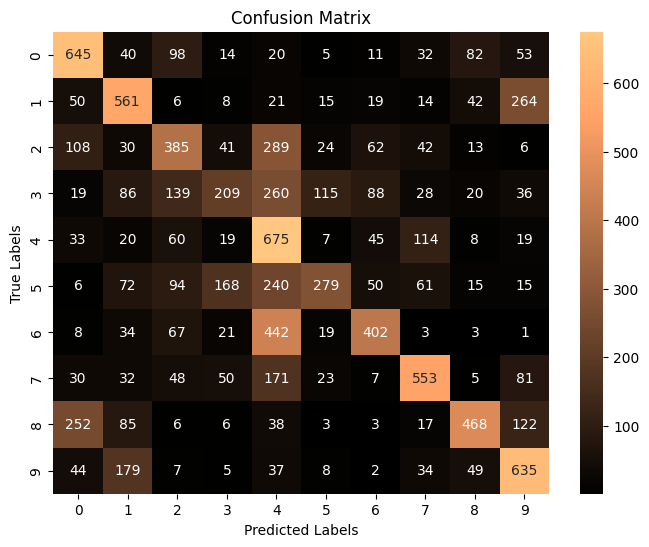

32691/32691 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 131s 6ms/step - accuracy: 0.2844 - loss: 1.9953
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 6: 
F1 Score: 0.47165194599687993
Accuracy: 0.4848



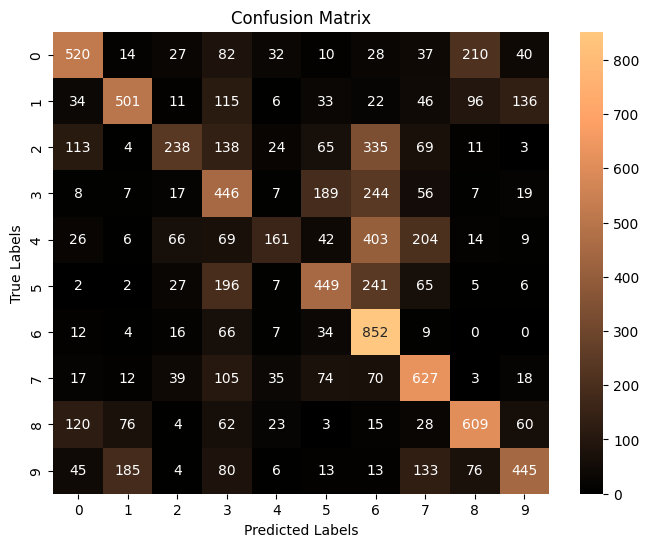

30191/30191 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 151s 6ms/step - accuracy: 0.3075 - loss: 1.9669
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 7: 
F1 Score: 0.5171238018070435
Accuracy: 0.5168



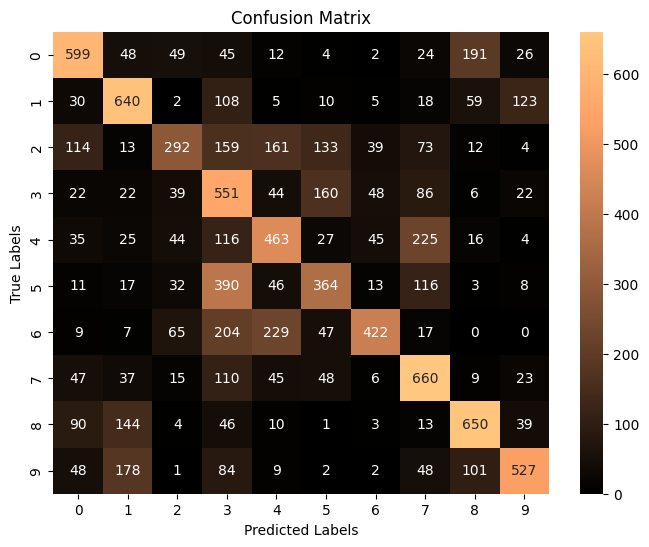

27691/27691 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 166s 6ms/step - accuracy: 0.2951 - loss: 1.9913
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 8: 
F1 Score: 0.516221204570544
Accuracy: 0.5192



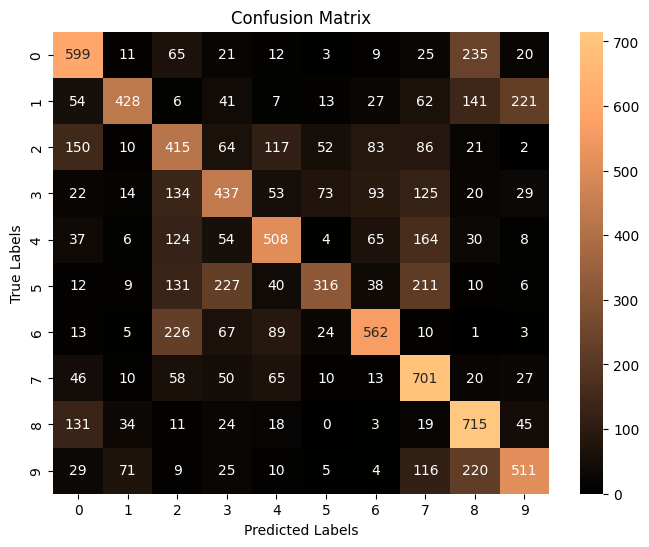

25191/25191 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


27500/27500 ━━━━━━━━━━━━━━━━━━━━ 177s 6ms/step - accuracy: 0.2982 - loss: 1.9423
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 9: 
F1 Score: 0.4766073421614853
Accuracy: 0.4879



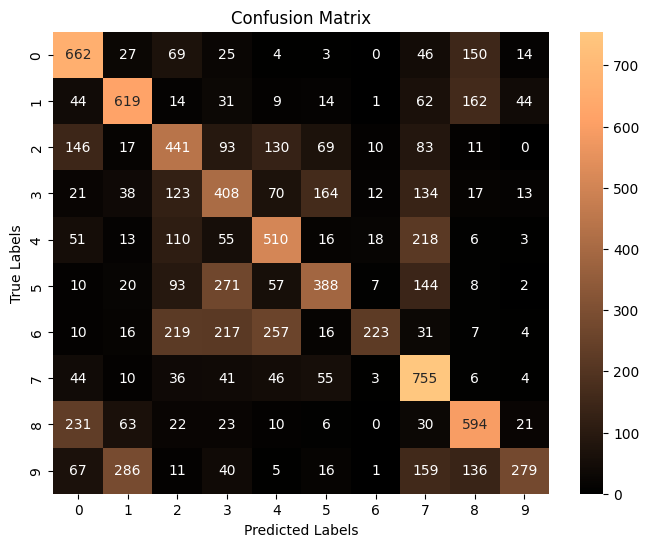

22691/22691 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step - accuracy: 0.3047 - loss: 1.9257
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 10: 
F1 Score: 0.5138639145012632
Accuracy: 0.5229



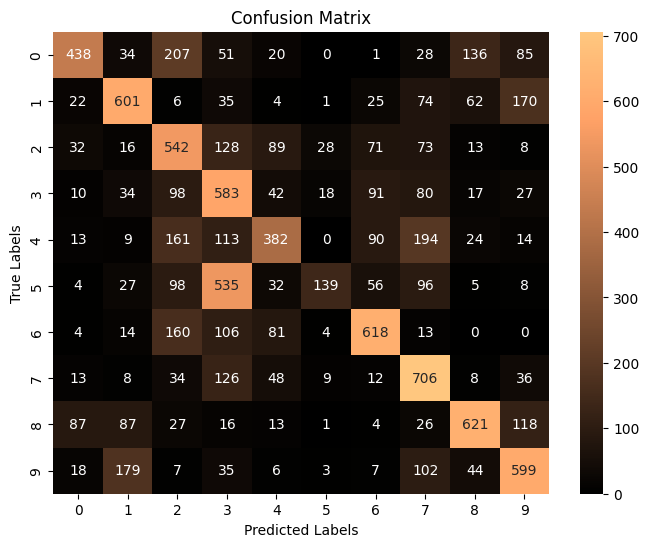

20191/20191 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


32500/32500 ━━━━━━━━━━━━━━━━━━━━ 206s 6ms/step - accuracy: 0.3212 - loss: 1.8899
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 11: 
F1 Score: 0.5238477466758844
Accuracy: 0.525



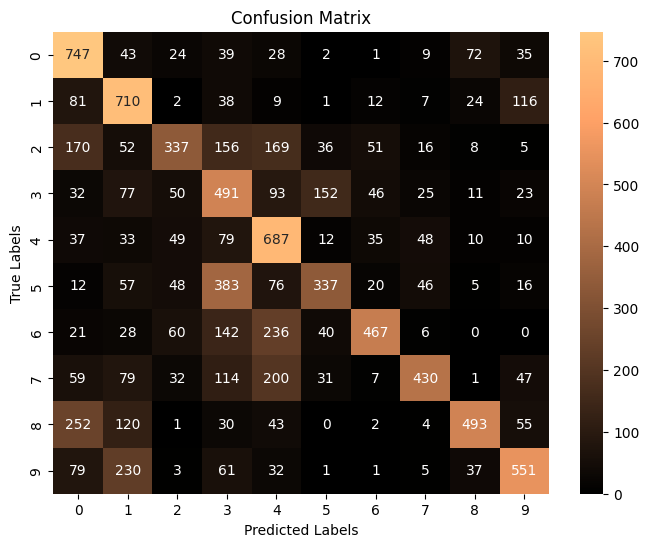

17691/17691 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 223s 6ms/step - accuracy: 0.3354 - loss: 1.8412
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 12: 
F1 Score: 0.5190880489341596
Accuracy: 0.5281



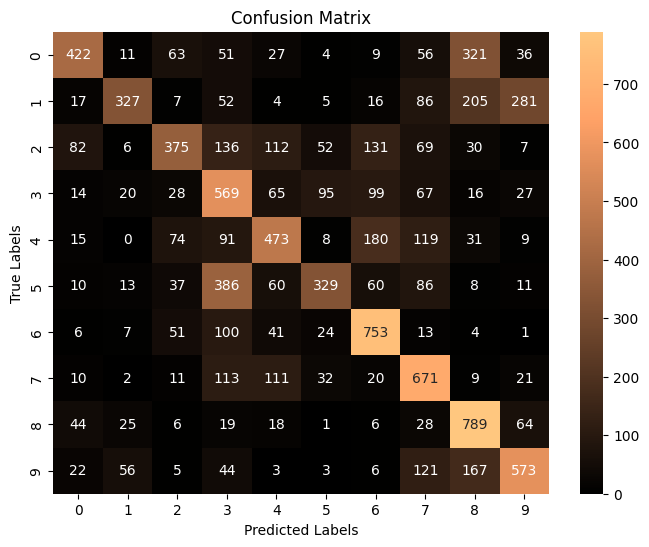

15191/15191 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


37500/37500 ━━━━━━━━━━━━━━━━━━━━ 240s 6ms/step - accuracy: 0.3569 - loss: 1.7957
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 13: 
F1 Score: 0.5139506360395247
Accuracy: 0.5211



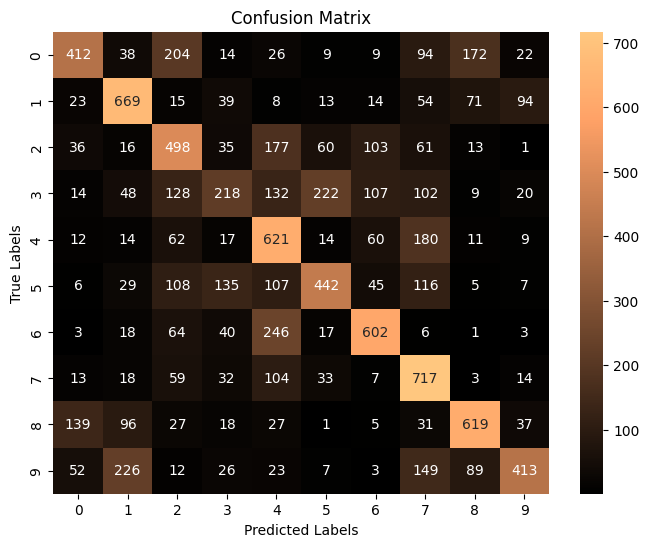

12691/12691 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 259s 6ms/step - accuracy: 0.3646 - loss: 1.7924
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 14: 
F1 Score: 0.5214938939452245
Accuracy: 0.5292



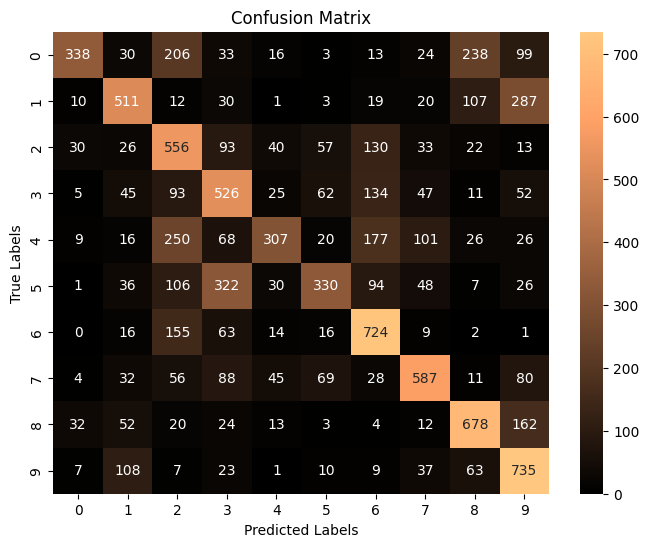

10191/10191 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


42500/42500 ━━━━━━━━━━━━━━━━━━━━ 268s 6ms/step - accuracy: 0.3779 - loss: 1.7437
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 15: 
F1 Score: 0.5478409361811206
Accuracy: 0.5512



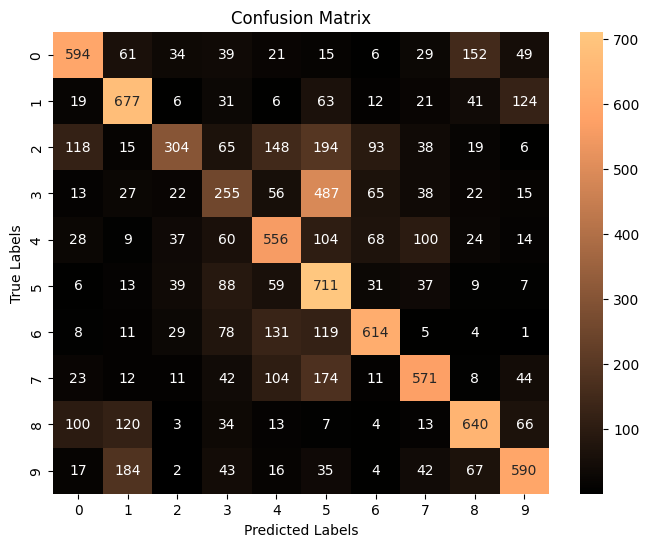

In [9]:
# Running active learning loops
print("Running active learning using entropy sampling: ")
f1_scores_entropy, accuracy_entropy = active_learning_strategy(entropy_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Entropy Sampling Cycle**

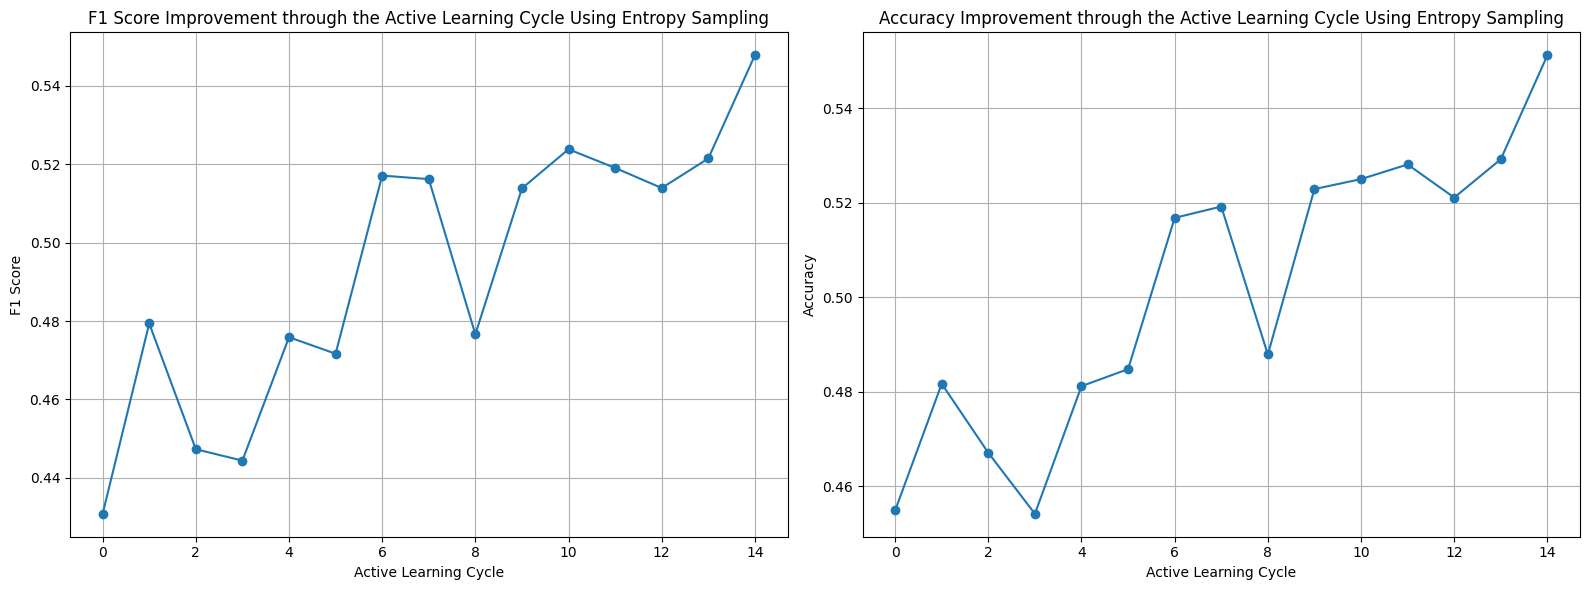

In [10]:
plot_metrics(f1_scores_entropy, accuracy_entropy, "Entropy Sampling")

## **The Active Learning Cycle Using Margin Sampling**

Running active learning using margin sampling: 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.3103 - loss: 2.0086
45191/45191 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.2975 - loss: 2.0271
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 1: 
F1 Score: 0.42881285447863077
Accuracy: 0.446



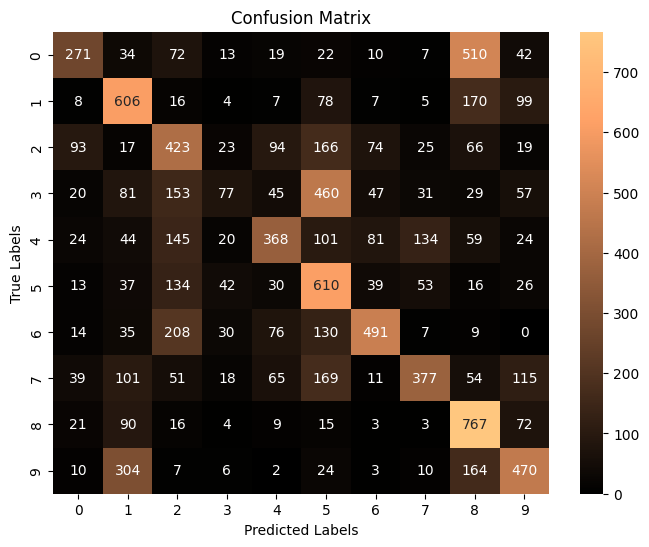

42691/42691 ━━━━━━━━━━━━━━━━━━━━ 172s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.2885 - loss: 2.0134
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 2: 
F1 Score: 0.4789282584110957
Accuracy: 0.494



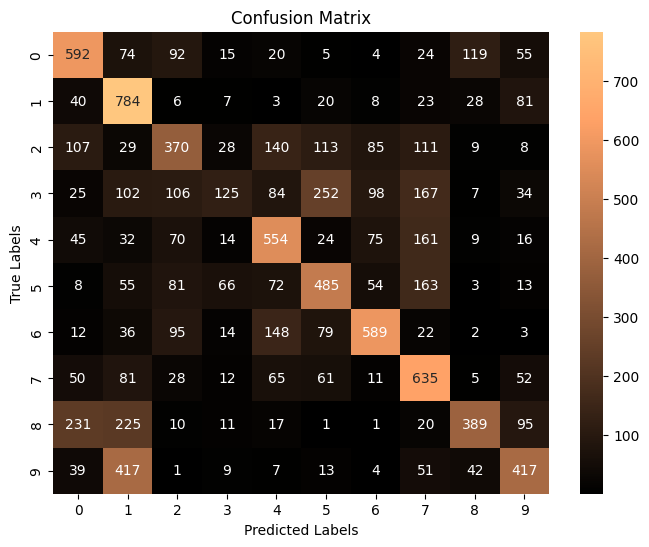

40191/40191 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.2881 - loss: 1.9903
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 3: 
F1 Score: 0.47674156633126225
Accuracy: 0.4819



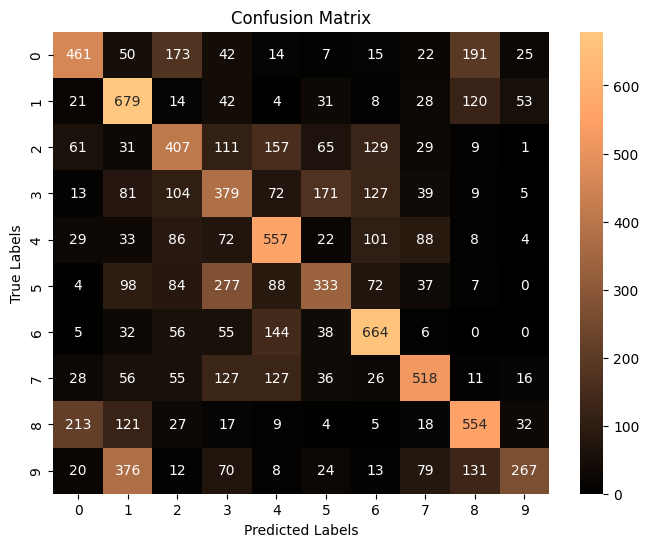

37691/37691 ━━━━━━━━━━━━━━━━━━━━ 154s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step - accuracy: 0.2883 - loss: 1.9879
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 4: 
F1 Score: 0.44732772597020365
Accuracy: 0.4702



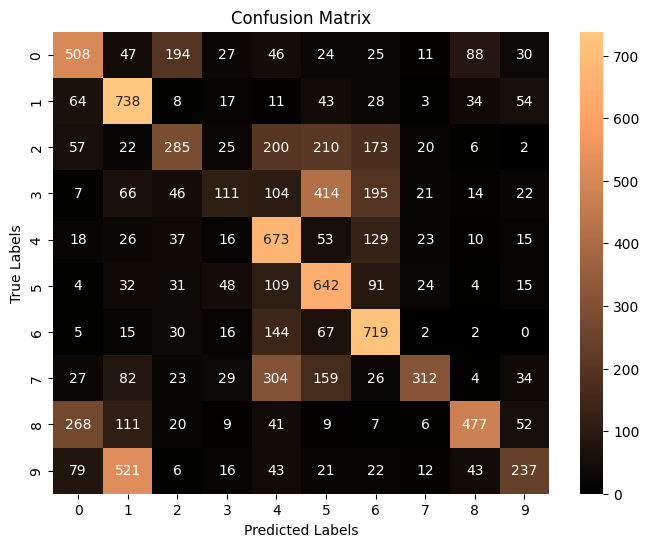

35191/35191 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 112s 6ms/step - accuracy: 0.2987 - loss: 1.9592
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 5: 
F1 Score: 0.48575148532011736
Accuracy: 0.4964



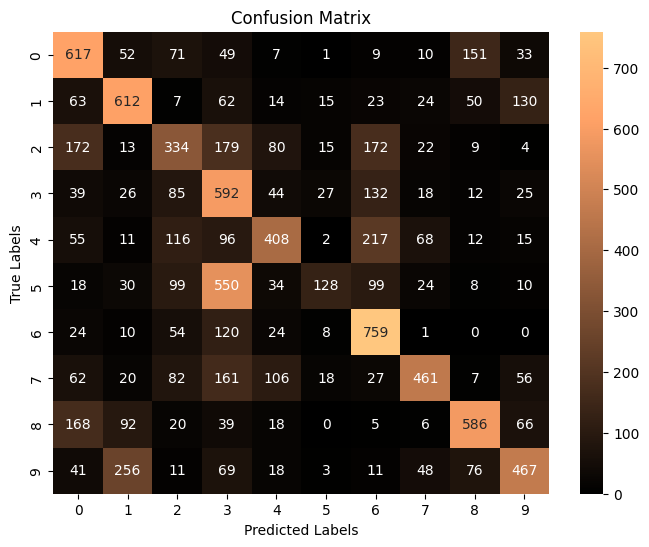

32691/32691 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 129s 6ms/step - accuracy: 0.2998 - loss: 1.9384
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 6: 
F1 Score: 0.49463144495219646
Accuracy: 0.5038



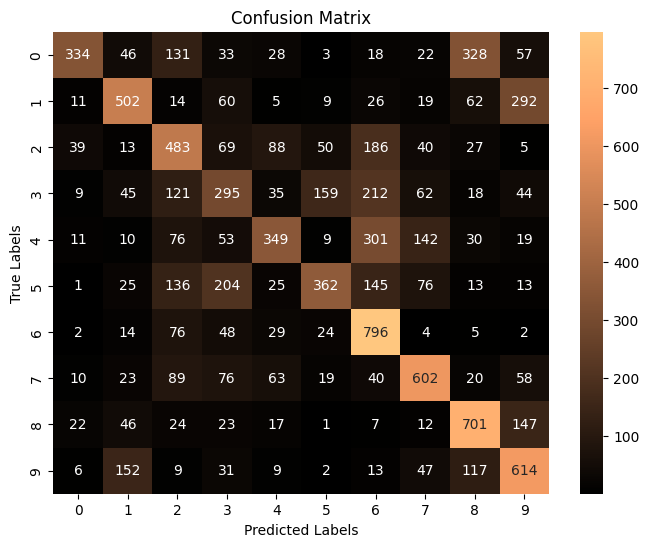

30191/30191 ━━━━━━━━━━━━━━━━━━━━ 122s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - accuracy: 0.3121 - loss: 1.8973
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 7: 
F1 Score: 0.517674816790158
Accuracy: 0.522



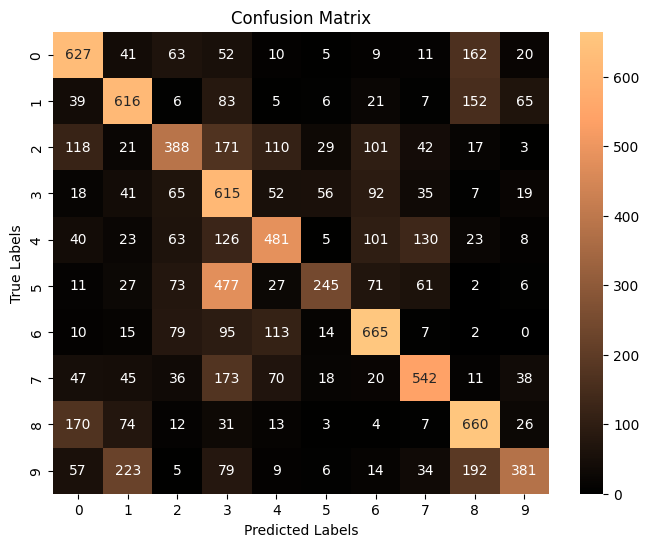

27691/27691 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 161s 6ms/step - accuracy: 0.3065 - loss: 1.9027
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 8: 
F1 Score: 0.515415157326253
Accuracy: 0.5237



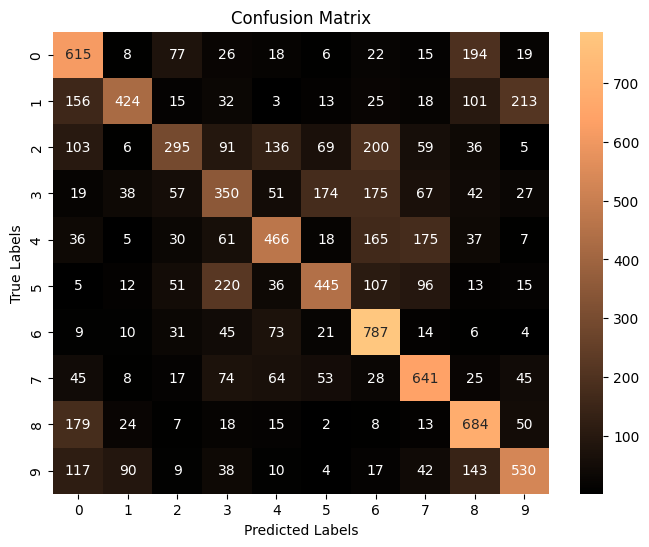

25191/25191 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


27500/27500 ━━━━━━━━━━━━━━━━━━━━ 173s 6ms/step - accuracy: 0.3191 - loss: 1.8844
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 9: 
F1 Score: 0.4708635705198888
Accuracy: 0.4794



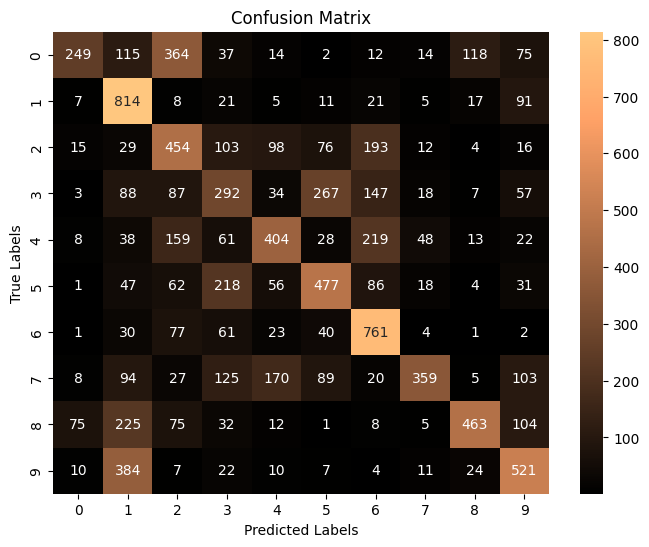

22691/22691 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - accuracy: 0.3262 - loss: 1.8663
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 10: 
F1 Score: 0.536249541561652
Accuracy: 0.5335



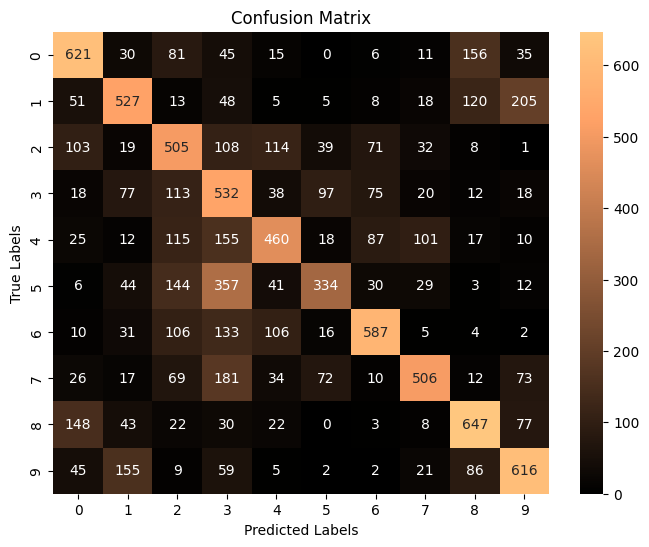

20191/20191 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


32500/32500 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - accuracy: 0.3347 - loss: 1.8255
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 11: 
F1 Score: 0.5342710316736329
Accuracy: 0.5446



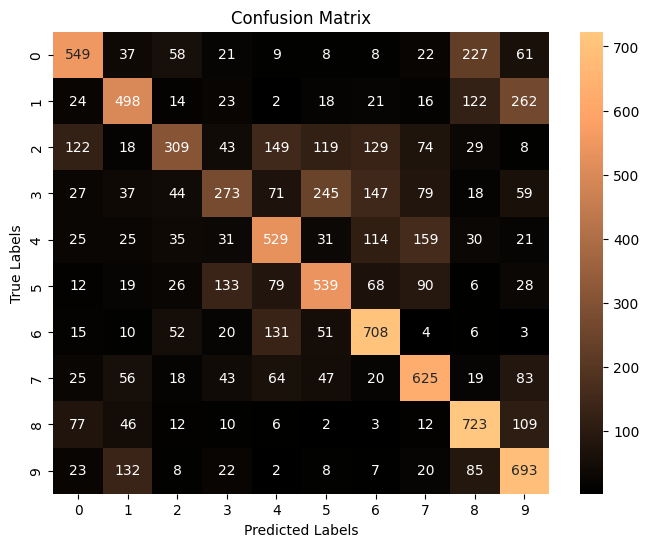

17691/17691 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 214s 6ms/step - accuracy: 0.3465 - loss: 1.8227
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 12: 
F1 Score: 0.543846979691166
Accuracy: 0.5433



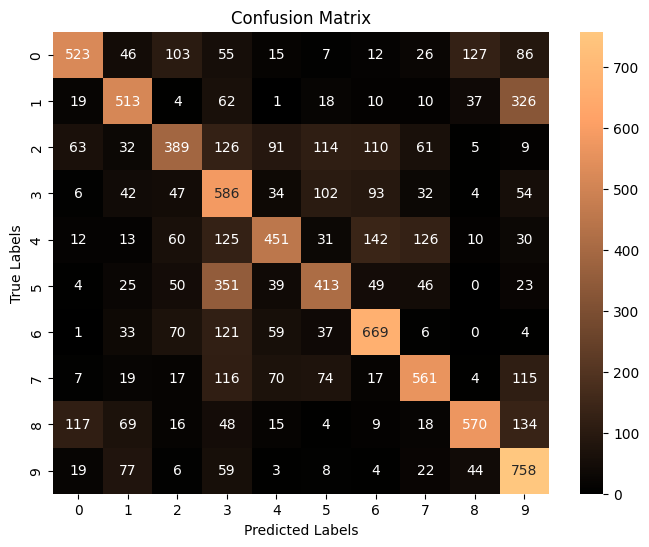

15191/15191 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


37500/37500 ━━━━━━━━━━━━━━━━━━━━ 231s 6ms/step - accuracy: 0.3476 - loss: 1.7980
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 13: 
F1 Score: 0.5546388649908369
Accuracy: 0.5559



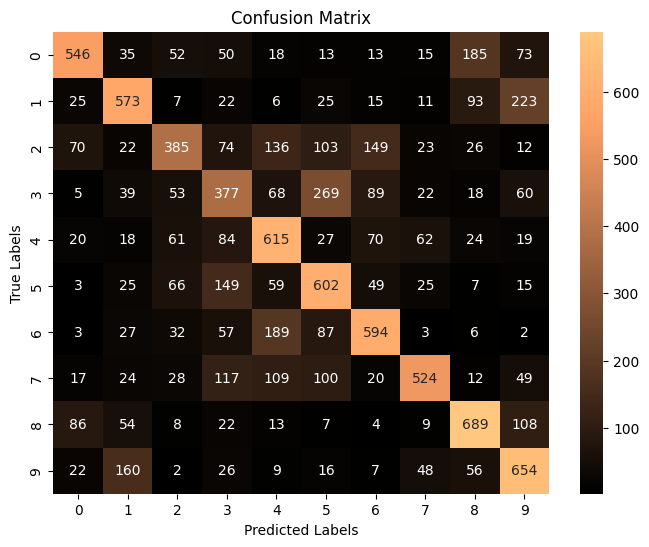

12691/12691 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 247s 6ms/step - accuracy: 0.3711 - loss: 1.7465
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Iteration 14: 
F1 Score: 0.5373527564235937
Accuracy: 0.5427



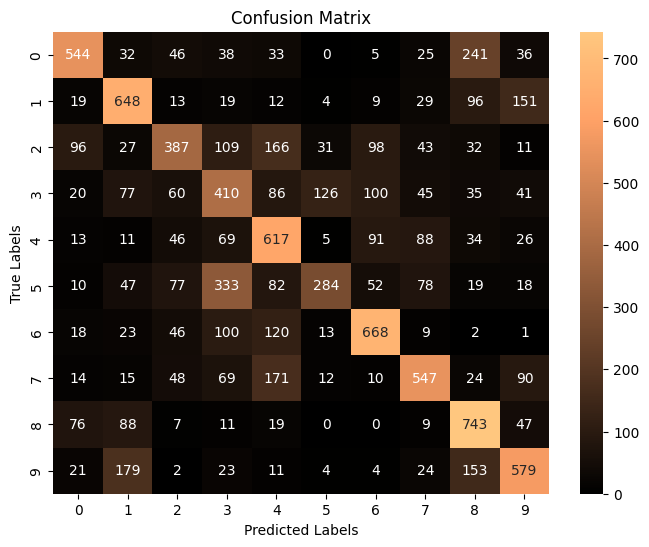

10191/10191 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


42500/42500 ━━━━━━━━━━━━━━━━━━━━ 264s 6ms/step - accuracy: 0.3786 - loss: 1.7271
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 15: 
F1 Score: 0.5384447168560365
Accuracy: 0.5468



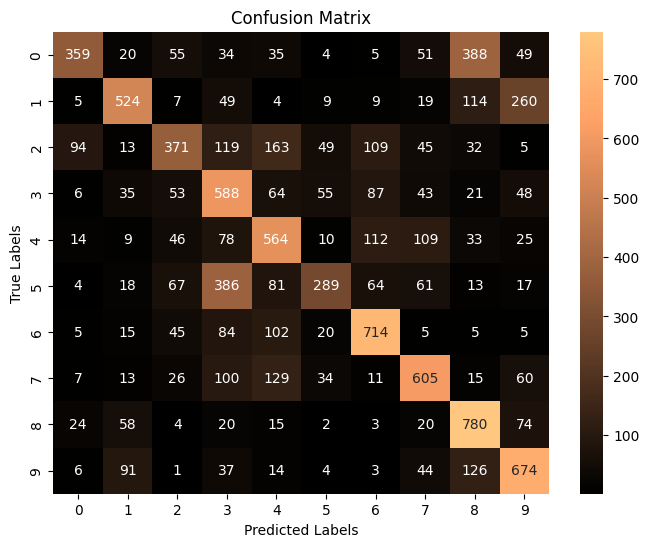

In [9]:
print("Running active learning using margin sampling: ")
f1_scores_margin, accuracy_margin = active_learning_strategy(margin_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Margin Sampling Cycle**

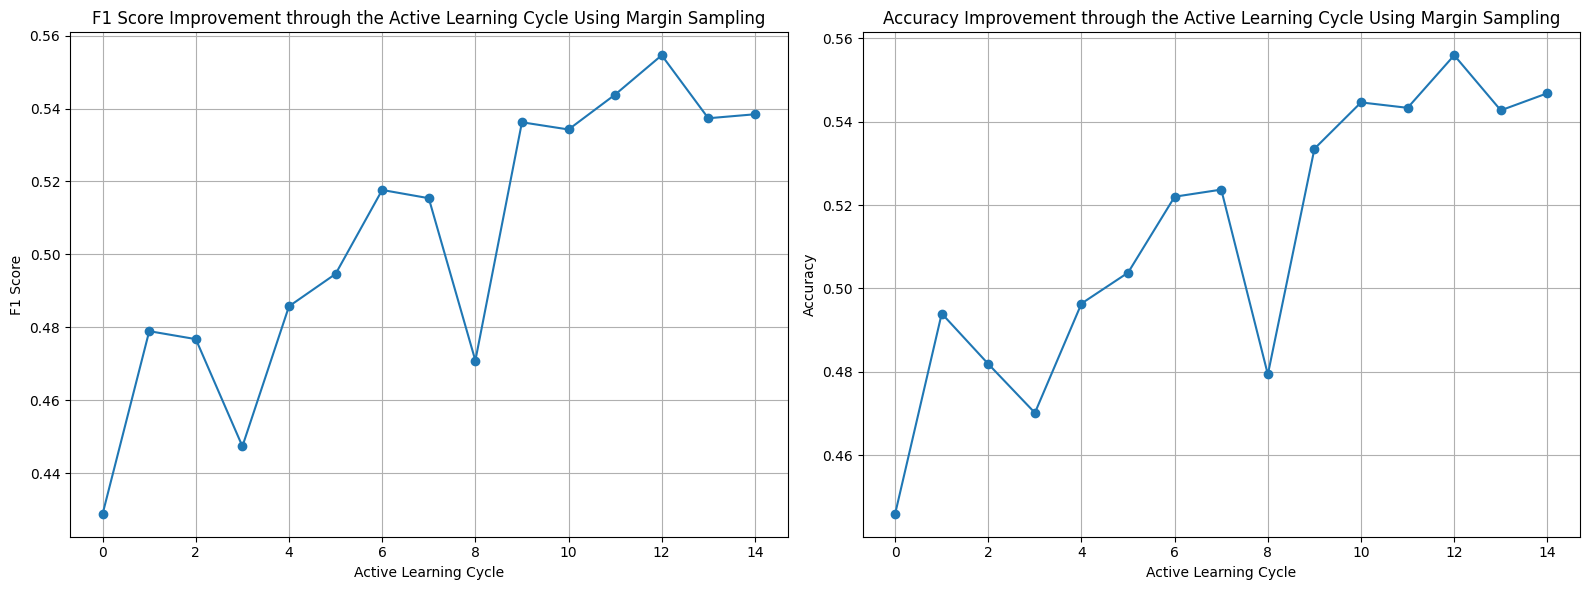

In [10]:
plot_metrics(f1_scores_margin, accuracy_margin, "Margin Sampling")

## **The Active Learning Cycle Using Uncertainty Sampling**

Running active learning using uncertainty sampling: 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.3125 - loss: 2.0149
45191/45191 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.2894 - loss: 2.0085
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 1: 
F1 Score: 0.469570702359621
Accuracy: 0.4764



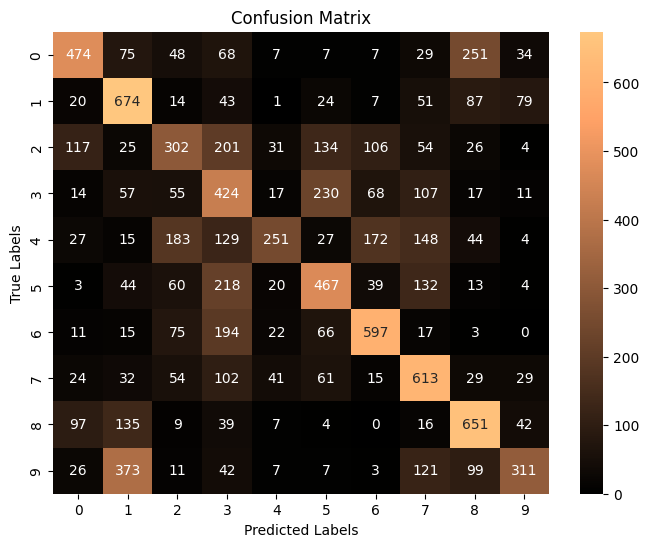

42691/42691 ━━━━━━━━━━━━━━━━━━━━ 174s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.2606 - loss: 2.1012
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 2: 
F1 Score: 0.45362815421180386
Accuracy: 0.4594



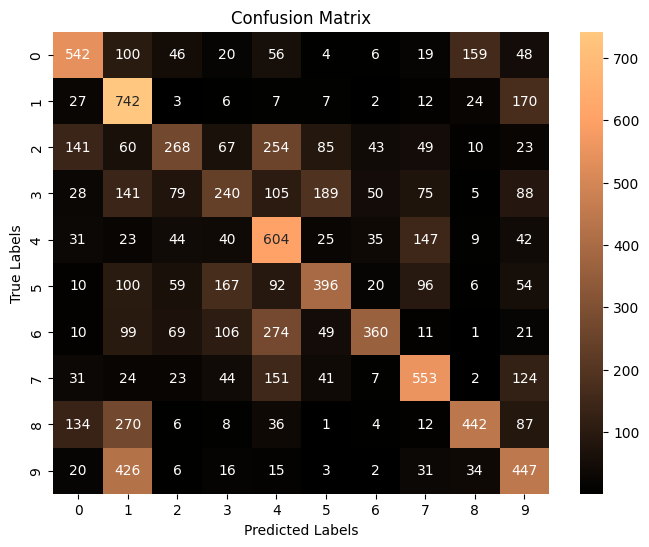

40191/40191 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - accuracy: 0.2538 - loss: 2.0700
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 3: 
F1 Score: 0.44191506628178767
Accuracy: 0.4515



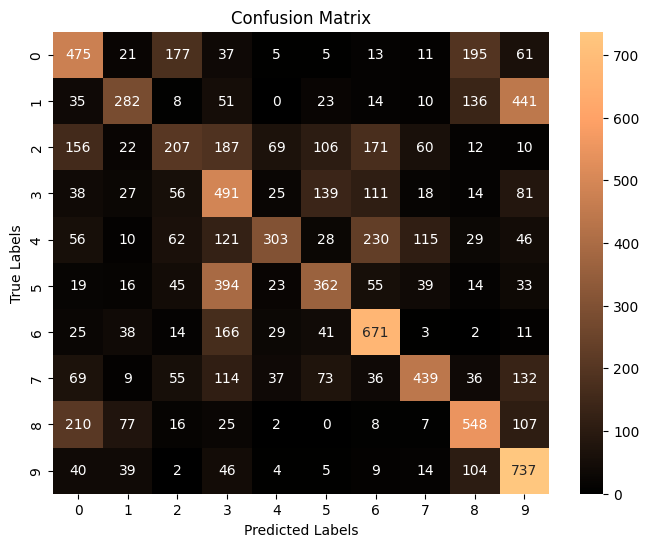

37691/37691 ━━━━━━━━━━━━━━━━━━━━ 155s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - accuracy: 0.2651 - loss: 2.0466
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 4: 
F1 Score: 0.48836850339691634
Accuracy: 0.4979



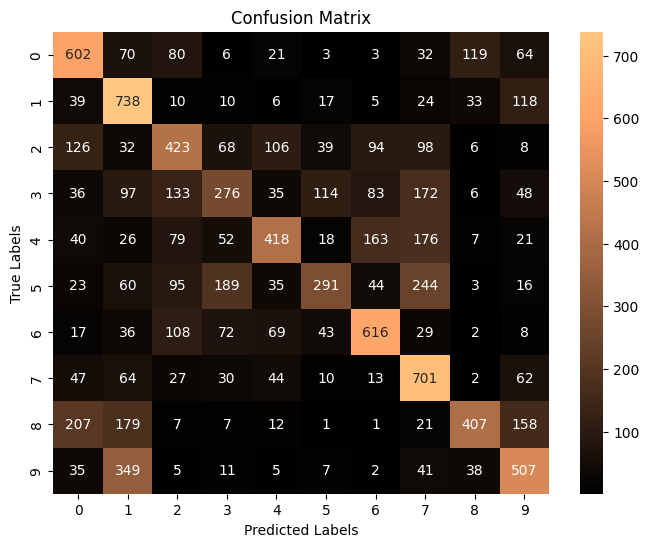

35191/35191 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - accuracy: 0.2682 - loss: 2.0522
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 5: 
F1 Score: 0.48554229826452083
Accuracy: 0.4935



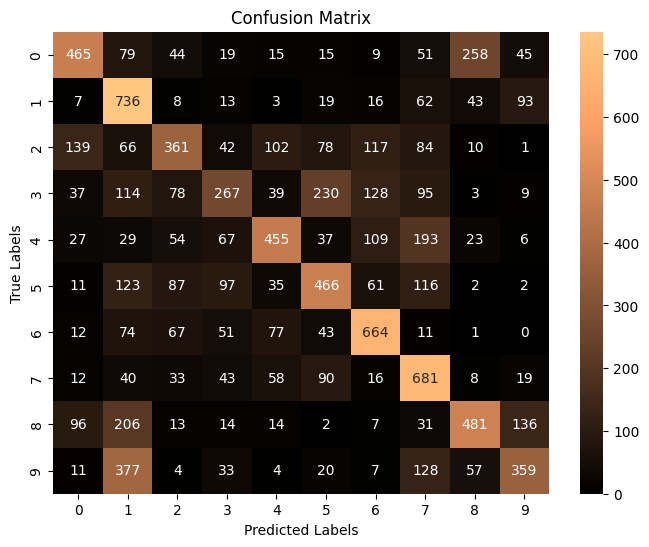

32691/32691 ━━━━━━━━━━━━━━━━━━━━ 132s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 133s 6ms/step - accuracy: 0.2772 - loss: 2.0208
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 6: 
F1 Score: 0.5103629107358244
Accuracy: 0.5137



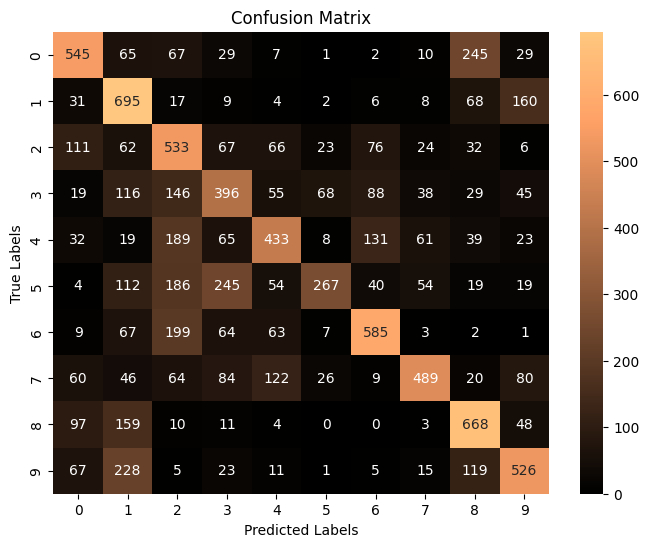

30191/30191 ━━━━━━━━━━━━━━━━━━━━ 122s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - accuracy: 0.2707 - loss: 2.0205
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 7: 
F1 Score: 0.4802413782234026
Accuracy: 0.4905



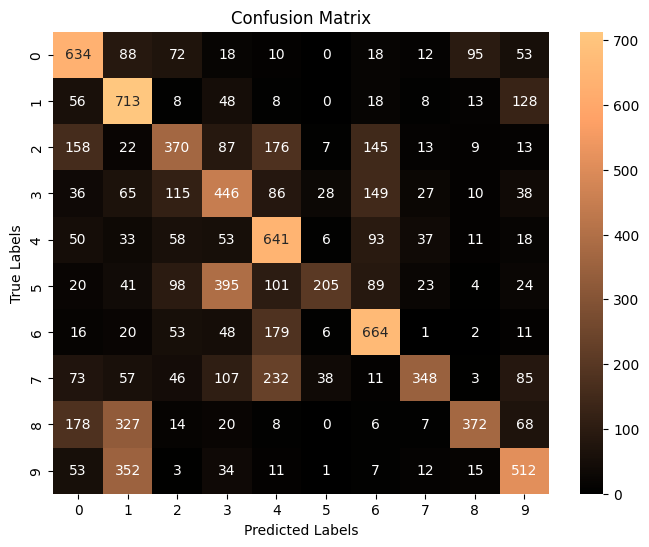

27691/27691 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 161s 6ms/step - accuracy: 0.2830 - loss: 1.9833
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 8: 
F1 Score: 0.4787641481703261
Accuracy: 0.4978



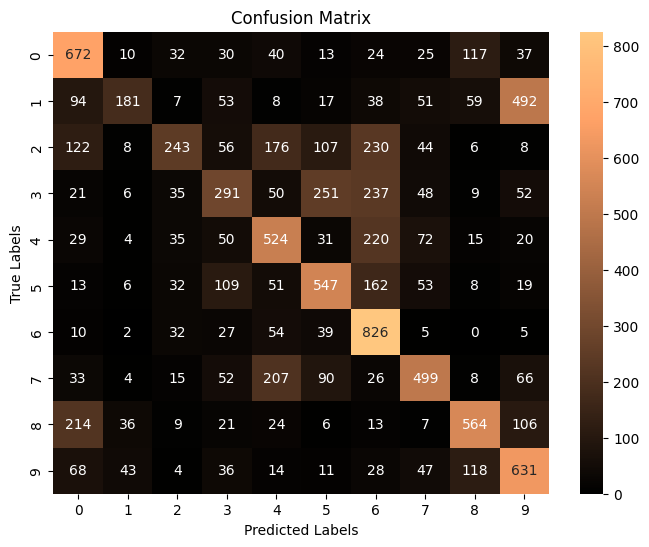

25191/25191 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


27500/27500 ━━━━━━━━━━━━━━━━━━━━ 175s 6ms/step - accuracy: 0.2941 - loss: 1.9614
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 9: 
F1 Score: 0.5008962120996604
Accuracy: 0.5068



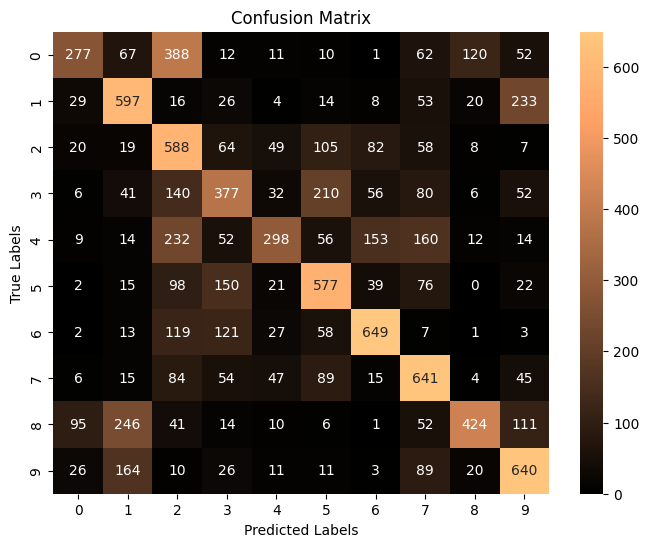

22691/22691 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step - accuracy: 0.3070 - loss: 1.9039
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 10: 
F1 Score: 0.4887977392077697
Accuracy: 0.4923



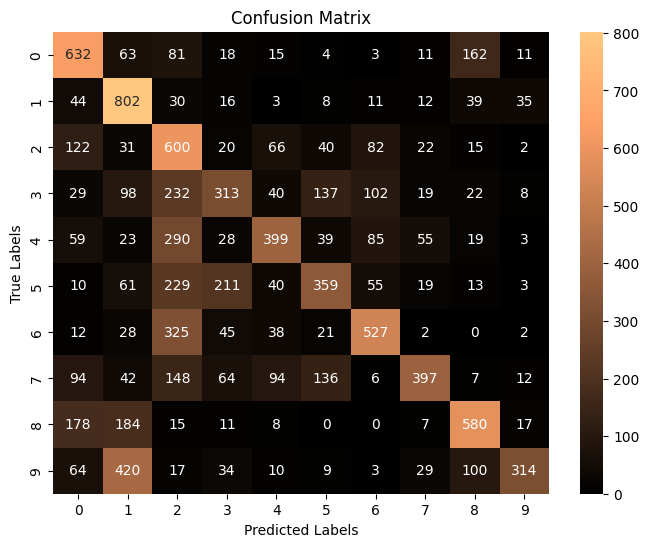

20191/20191 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


32500/32500 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - accuracy: 0.3190 - loss: 1.8882
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 11: 
F1 Score: 0.5061685108553342
Accuracy: 0.5121



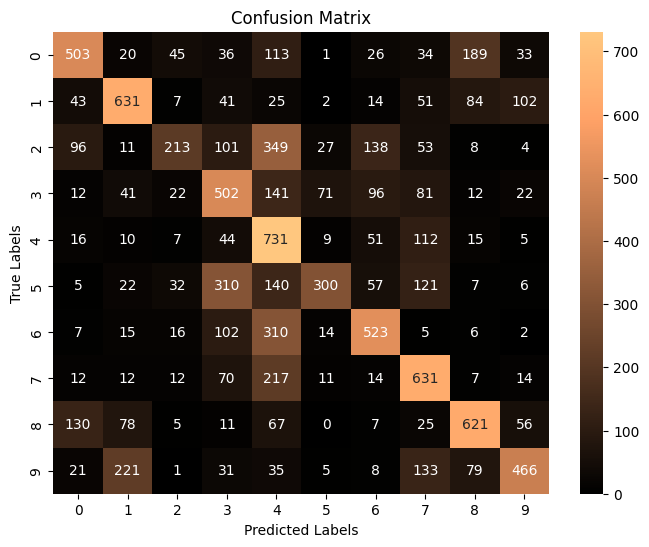

17691/17691 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 220s 6ms/step - accuracy: 0.3387 - loss: 1.8295
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 12: 
F1 Score: 0.53781850981964
Accuracy: 0.5402



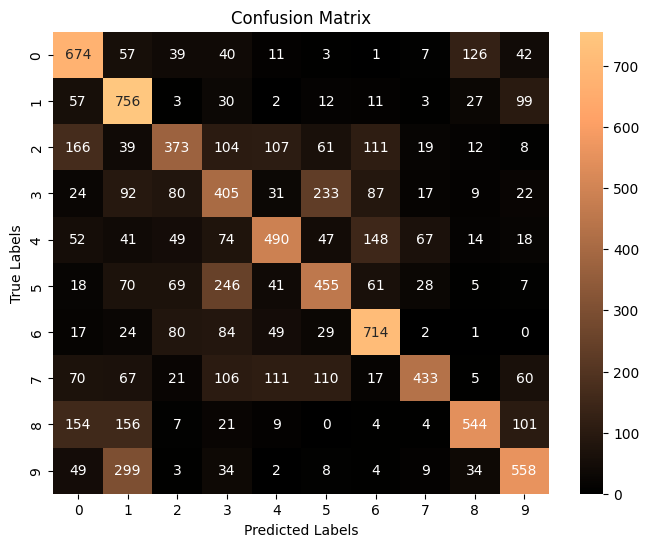

15191/15191 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


37500/37500 ━━━━━━━━━━━━━━━━━━━━ 238s 6ms/step - accuracy: 0.3452 - loss: 1.8136
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 13: 
F1 Score: 0.5317533886326462
Accuracy: 0.535



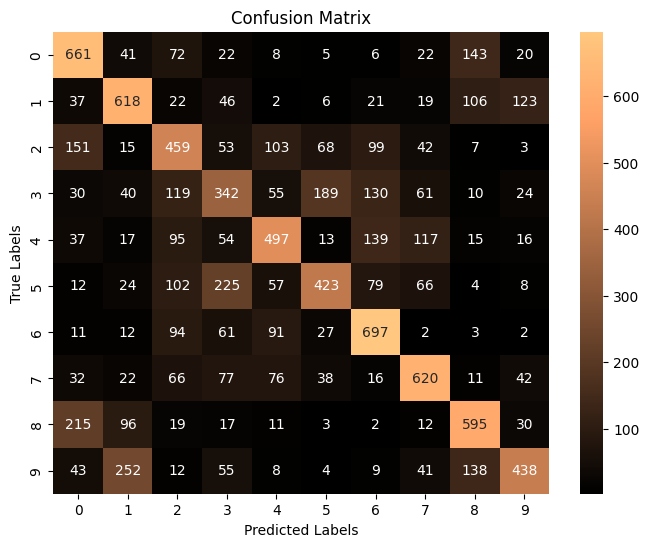

12691/12691 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 253s 6ms/step - accuracy: 0.3526 - loss: 1.7942
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 14: 
F1 Score: 0.5239984679331819
Accuracy: 0.5326



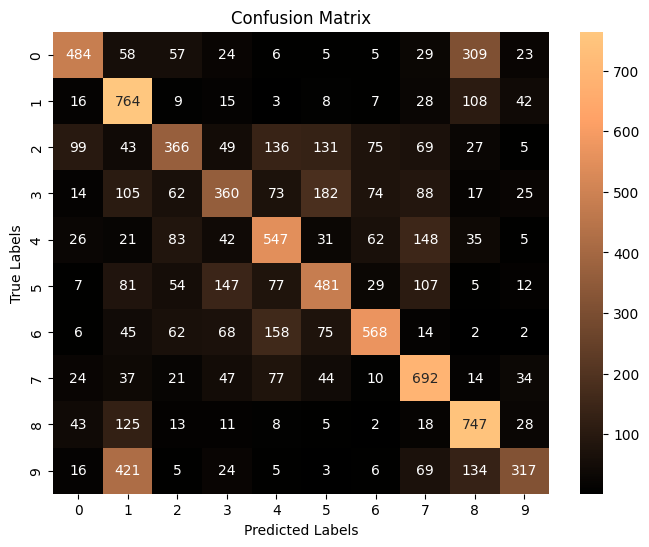

10191/10191 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


42500/42500 ━━━━━━━━━━━━━━━━━━━━ 264s 6ms/step - accuracy: 0.3795 - loss: 1.7328
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 15: 
F1 Score: 0.5248798233424006
Accuracy: 0.5334



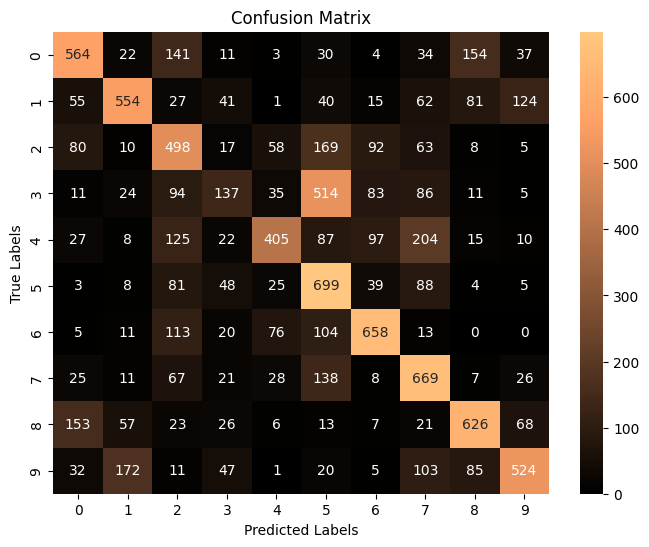

In [9]:
print("Running active learning using uncertainty sampling: ")
f1_scores_uncertainty, accuracy_uncertainty = active_learning_strategy(uncertainty_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Uncertainty Sampling Cycle**

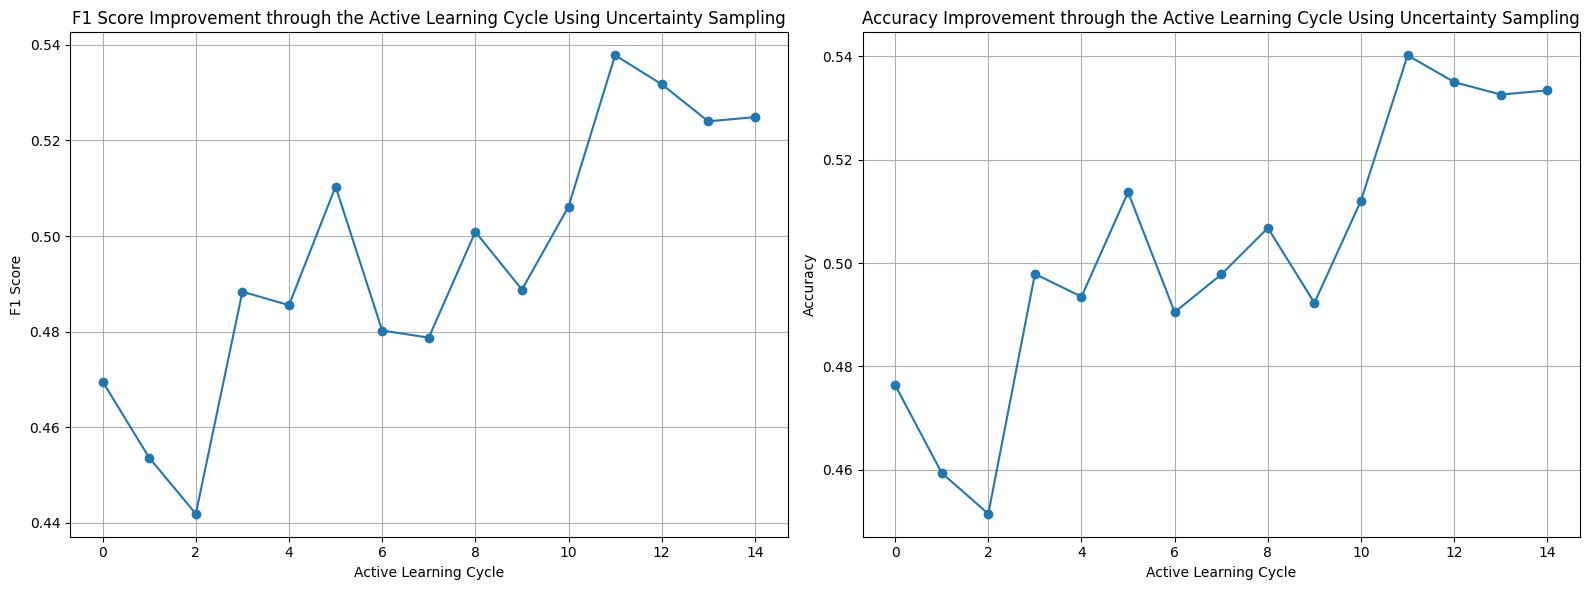

In [10]:
plot_metrics(f1_scores_uncertainty, accuracy_uncertainty, "Uncertainty Sampling")+

## **The Active Learning Cycle Using Consensus Entropy Sampling**

Running active learning using consensus entropy sampling: 
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.2972 - loss: 2.0046
45191/45191 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.2674 - loss: 2.1004
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 1: 
F1 Score: 0.44766581626947954
Accuracy: 0.4505



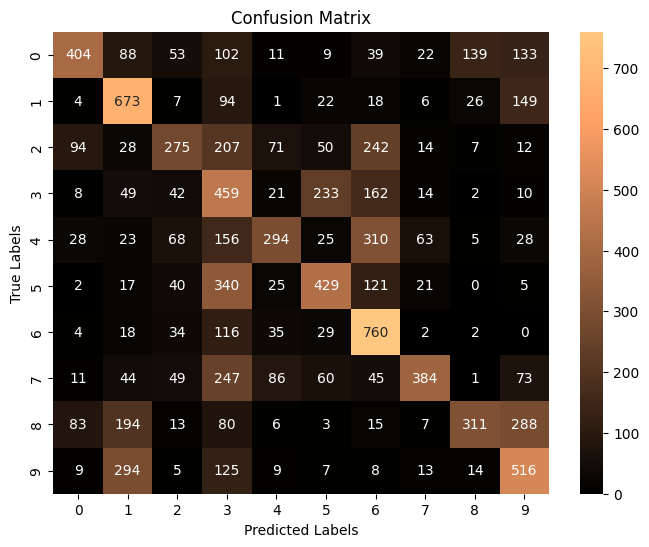

42691/42691 ━━━━━━━━━━━━━━━━━━━━ 178s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.2559 - loss: 2.1354
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 2: 
F1 Score: 0.45077421203070545
Accuracy: 0.4601



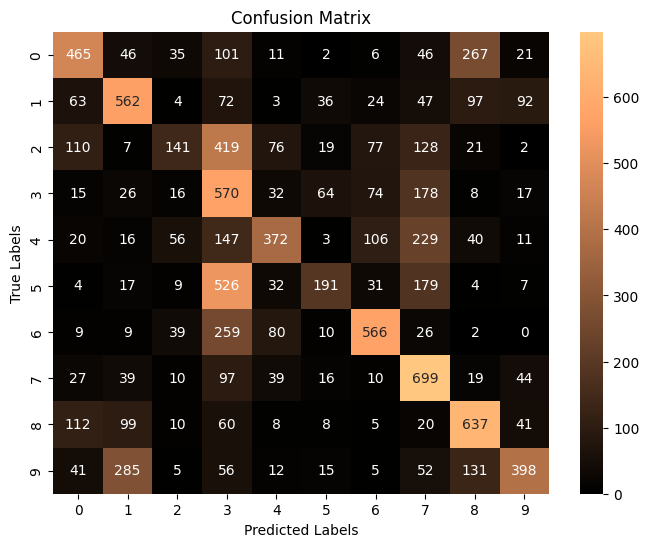

40191/40191 ━━━━━━━━━━━━━━━━━━━━ 169s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.2677 - loss: 2.0951
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Iteration 3: 
F1 Score: 0.4749575011844742
Accuracy: 0.4771



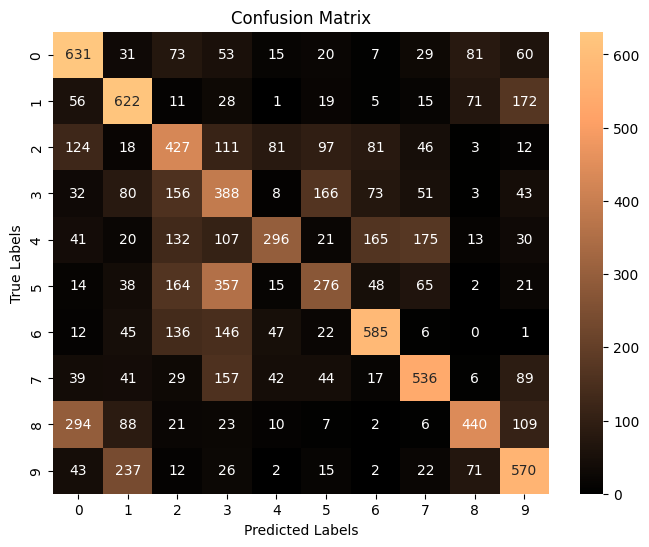

37691/37691 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - accuracy: 0.2620 - loss: 2.0874
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 4: 
F1 Score: 0.472949312190533
Accuracy: 0.4887



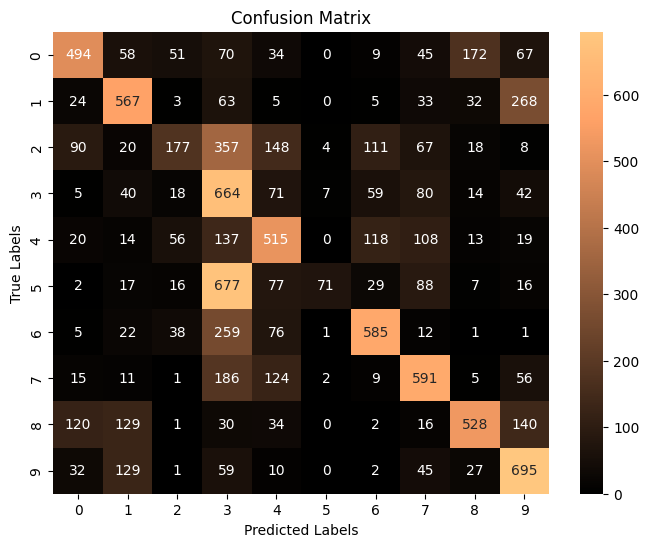

35191/35191 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - accuracy: 0.2762 - loss: 2.0628
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 5: 
F1 Score: 0.5135134434856566
Accuracy: 0.5166



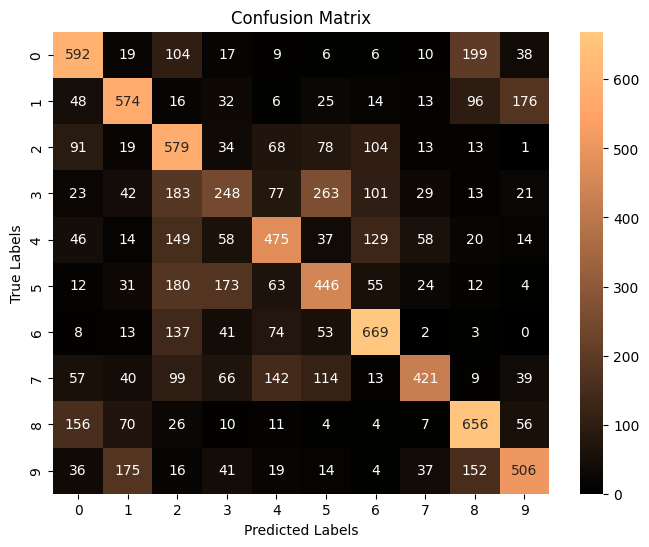

32691/32691 ━━━━━━━━━━━━━━━━━━━━ 132s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - accuracy: 0.2769 - loss: 2.0182
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 6: 
F1 Score: 0.4393782415774236
Accuracy: 0.4618



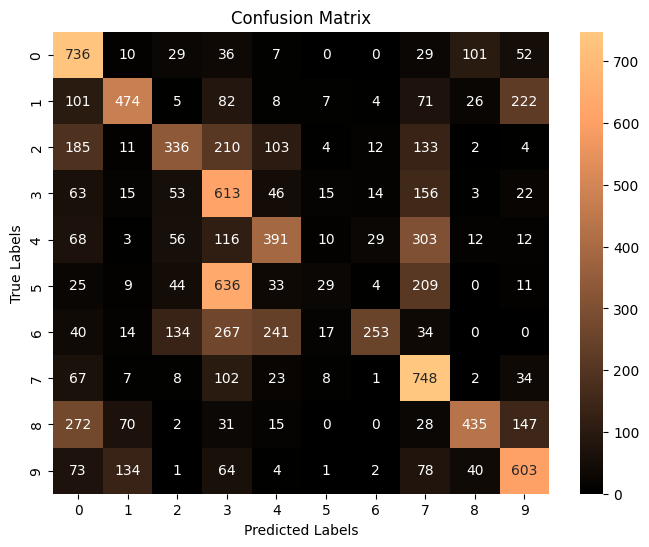

30191/30191 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 149s 6ms/step - accuracy: 0.2911 - loss: 1.9913
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 7: 
F1 Score: 0.4754103884705046
Accuracy: 0.4963



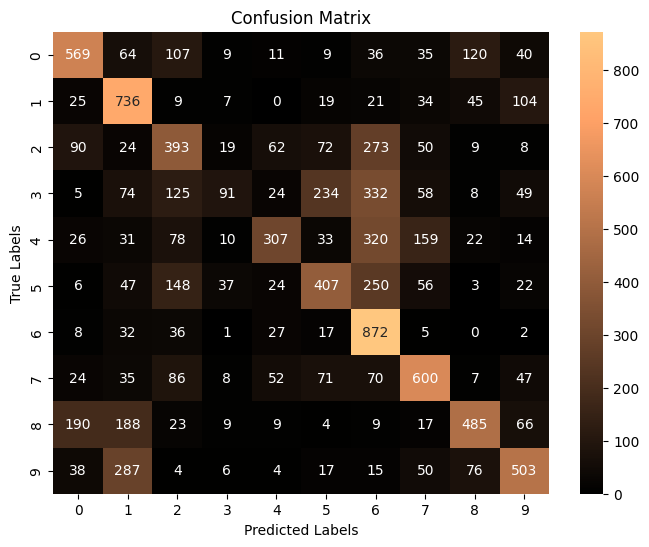

27691/27691 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 164s 6ms/step - accuracy: 0.3025 - loss: 1.9346
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 8: 
F1 Score: 0.5158244892147347
Accuracy: 0.5176



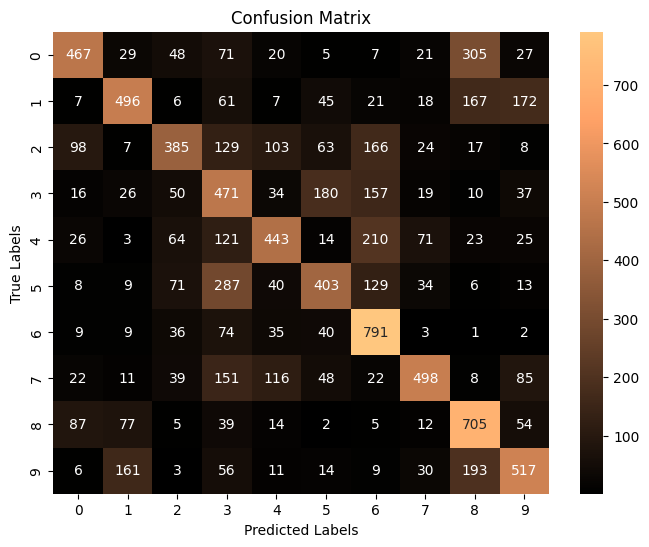

25191/25191 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


27500/27500 ━━━━━━━━━━━━━━━━━━━━ 177s 6ms/step - accuracy: 0.3177 - loss: 1.9363
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 9: 
F1 Score: 0.5194555127019199
Accuracy: 0.5233



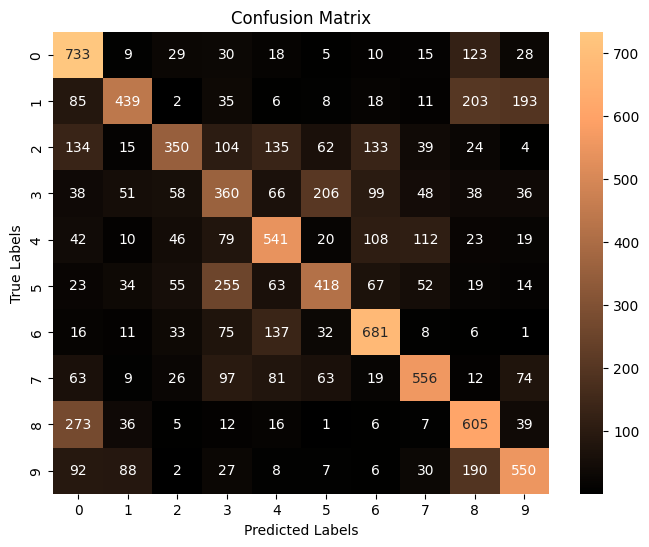

22691/22691 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 194s 6ms/step - accuracy: 0.3231 - loss: 1.9036
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 10: 
F1 Score: 0.5209983597141868
Accuracy: 0.5204



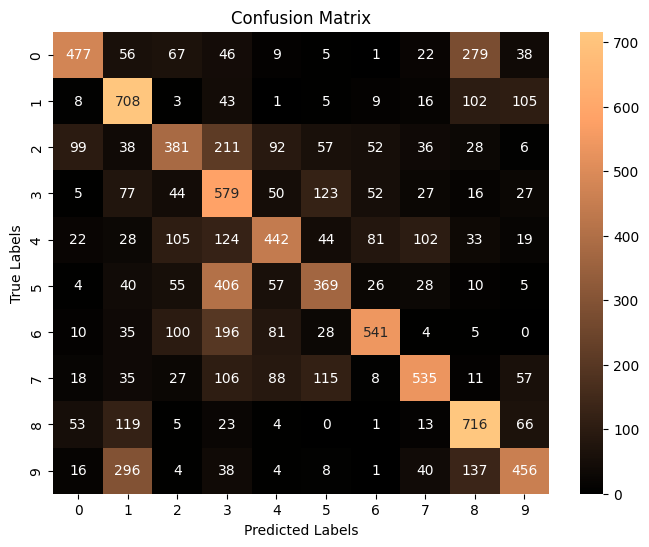

20191/20191 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


32500/32500 ━━━━━━━━━━━━━━━━━━━━ 210s 6ms/step - accuracy: 0.3335 - loss: 1.8689
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 11: 
F1 Score: 0.5063674562795629
Accuracy: 0.5088



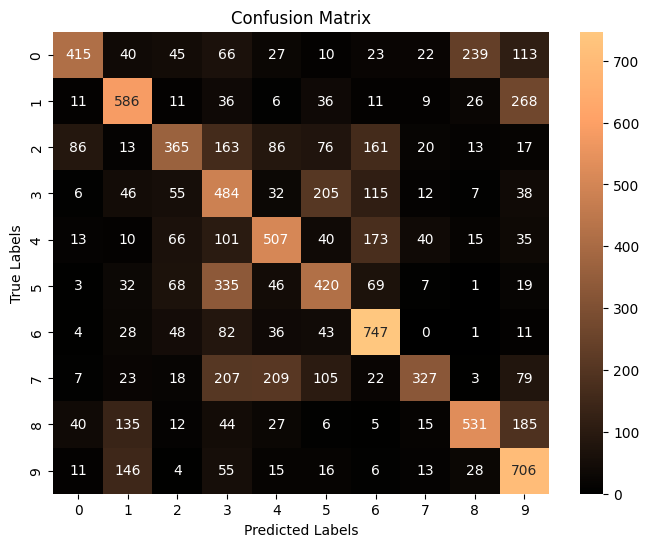

17691/17691 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 228s 6ms/step - accuracy: 0.3383 - loss: 1.8499
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 12: 
F1 Score: 0.5182919732551639
Accuracy: 0.5274



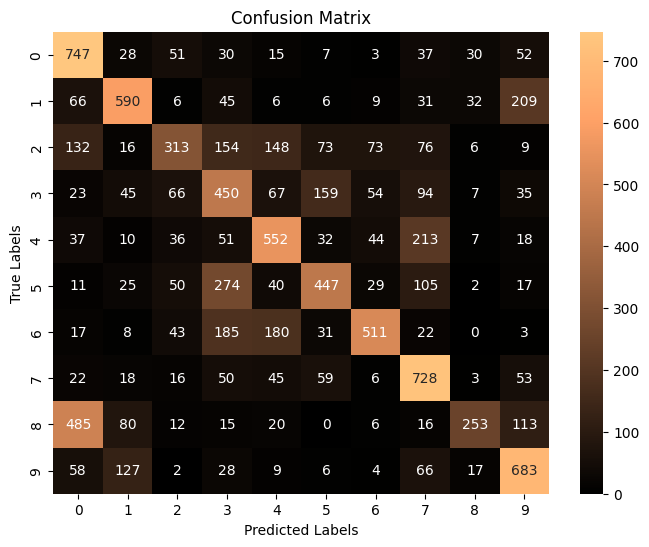

15191/15191 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


37500/37500 ━━━━━━━━━━━━━━━━━━━━ 242s 6ms/step - accuracy: 0.3496 - loss: 1.8233
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 13: 
F1 Score: 0.513574296856353
Accuracy: 0.5301



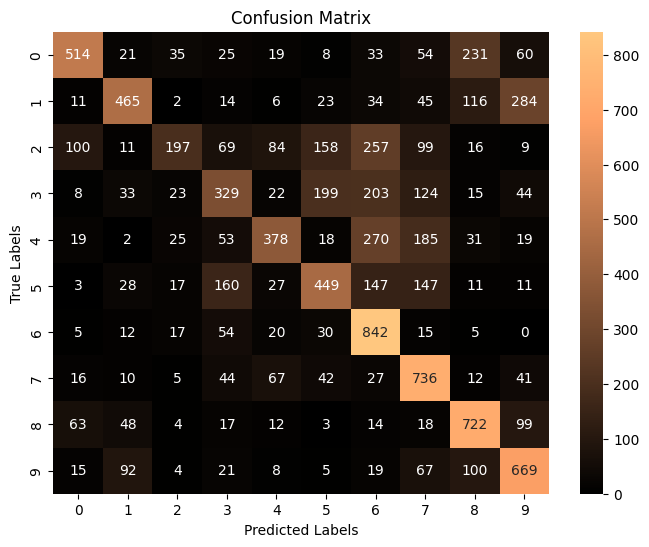

12691/12691 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 259s 6ms/step - accuracy: 0.3735 - loss: 1.7618
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step
Iteration 14: 
F1 Score: 0.5523820226125966
Accuracy: 0.5563



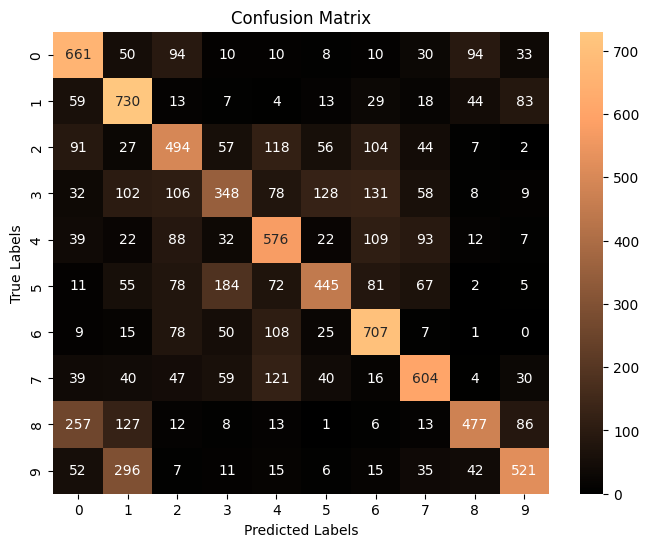

10191/10191 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


42500/42500 ━━━━━━━━━━━━━━━━━━━━ 276s 6ms/step - accuracy: 0.3788 - loss: 1.7358
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Iteration 15: 
F1 Score: 0.5493671532715046
Accuracy: 0.5454



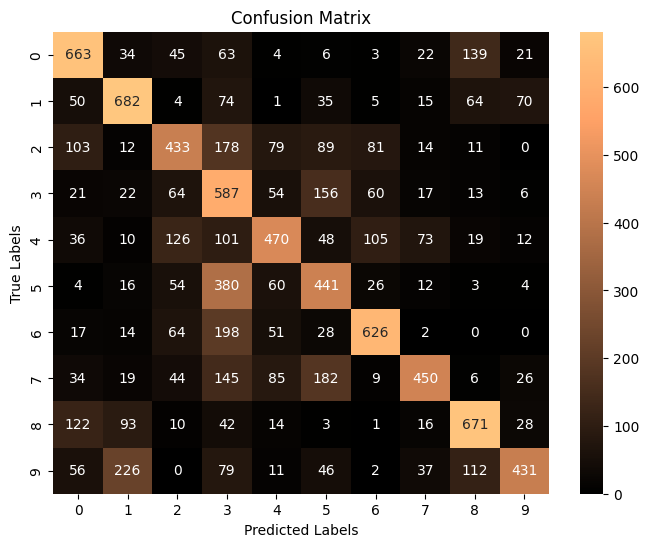

In [11]:
print("Running active learning using consensus entropy sampling: ")
f1_scores_consensus_entropy, accuracy_consensus_entropy = active_learning_strategy(consensus_entropy_sampling, X_initial.copy() ,y_initial.copy() ,X_pool.copy(), y_pool.copy(), X_test, y_test)

## **Plotting the Results of the Consensus Entropy Sampling Cycle**

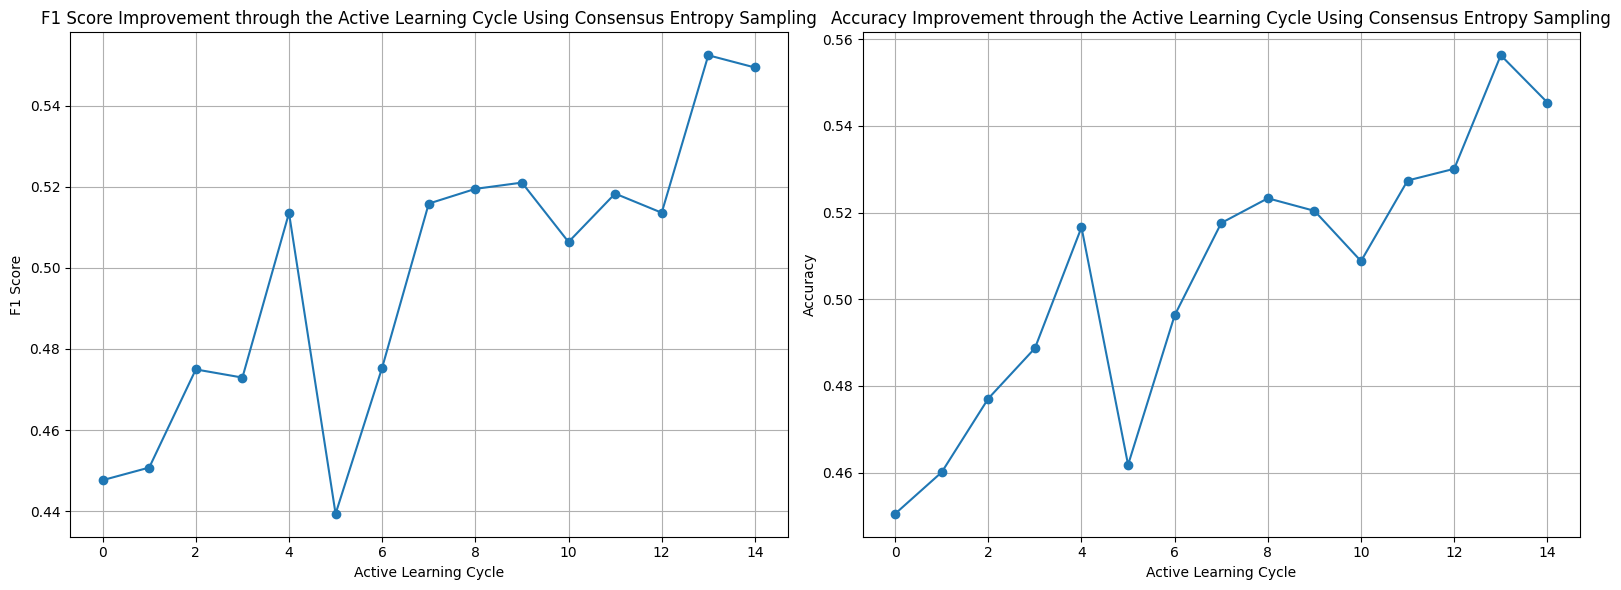

In [12]:
plot_metrics(f1_scores_consensus_entropy, accuracy_consensus_entropy, "Consensus Entropy Sampling")

## **Putting all Plots Together**

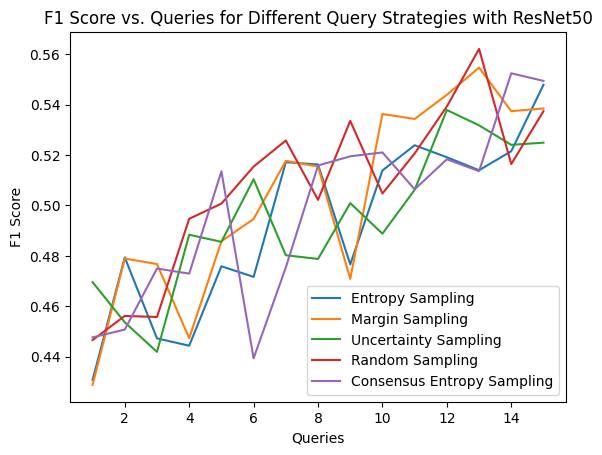

In [3]:
n_queries = 15
# Plot F1 scores for each query
plt.plot(range(1, n_queries + 1), f1_scores_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_random_sampling, label='Random Sampling')
plt.plot(range(1, n_queries + 1), f1_scores_consensus_entropy, label='Consensus Entropy Sampling')
plt.xlabel('Queries')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Queries for Different Query Strategies with ResNet50')
plt.legend()
plt.show()

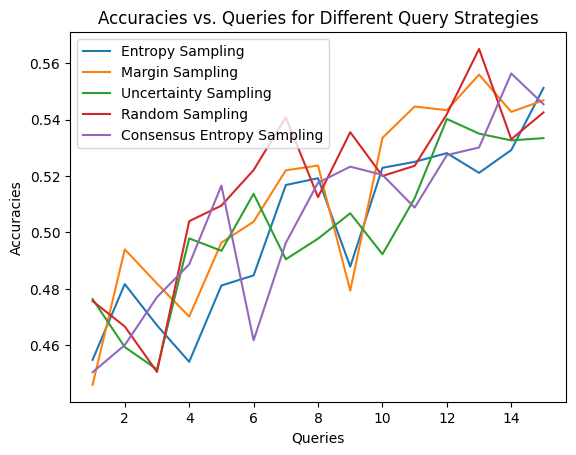

In [4]:
# Plot F1 scores for each query
plt.plot(range(1, n_queries + 1), accuracy_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), accuracy_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), accuracy_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), accuracy_random_sampling, label='Random Sampling')
plt.plot(range(1, n_queries + 1), accuracy_consensus_entropy, label='Consensus Entropy Sampling')
plt.xlabel('Queries')
plt.ylabel('Accuracies')
plt.title('Accuracies vs. Queries for Different Query Strategies')
plt.legend()
plt.show()